In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import json
import librosa # Library for audio analysis
import soundfile as sf # To read audio files reliably
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from scipy.stats import mode
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (GRU, Dense, Dropout, BatchNormalization,Input, Multiply, Lambda, Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# **SET_A**

In [ ]:
INPUT_DIR_A = "/content/drive/MyDrive/DIP | Final/Heart Beat Sound Data"
INPUT_DIR_A_WAVE = "/content/drive/MyDrive/DIP | Final/Heart Beat Sound Data/set_a"
INPUT_DIR_A_CSV = "/content/drive/MyDrive/DIP | Final/Heart Beat Sound Data/set_a.csv"
INPUT_DIR_A_TIMING_CSV = "/content/drive/MyDrive/DIP | Final/Heart Beat Sound Data/set_a_timing.csv"

# **SET_B**

In [ ]:
INPUT_DIR_A = "/content/drive/MyDrive/Colab Notebooks/Heartbeat"
INPUT_DIR_A_WAVE = "/content/drive/MyDrive/Digital Image Processing Lab/SER/Heart Beat Sound Data/set_b"
INPUT_DIR_A_CSV = "/content/drive/MyDrive/Digital Image Processing Lab/SER/Heart Beat Sound Data/set_b.csv"
INPUT_DIR_A_TIMING_CSV = "/content/drive/MyDrive/Digital Image Processing Lab/SER/Heart Beat Sound Data/set_b_timing.csv"

# **Data Preproccessing:**

In [ ]:
# --- Complete Code for Google Colab with Separate Epoch Training ---

# Step 1: Install and Import Libraries
# !pip install librosa soundfile scikit-learn tensorflow
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import matplotlib.pyplot as plt



# --- Step 3: Define Paths ---
INPUT_DIR_A = "/content/drive/MyDrive/DIP | Final/Heart Beat Sound Data"
INPUT_DIR_A_WAVE = "/content/drive/MyDrive/DIP | Final/Heart Beat Sound Data/set_a"
INPUT_DIR_A_CSV = "/content/drive/MyDrive/DIP | Final/Heart Beat Sound Data/set_a.csv"
INPUT_DIR_A_TIMING_CSV = "/content/drive/MyDrive/DIP | Final/Heart Beat Sound Data/set_a_timing.csv"

# --- Step 4: Load and Clean the Dataset ---
print("\nStep 4: Loading and cleaning the dataset...")
try:
    df_a = pd.read_csv(INPUT_DIR_A_CSV)
    print(f"Dataset loaded. Shape: {df_a.shape}")
    print(f"Label distribution:\n{df_a['label'].value_counts(dropna=False)}")

    # CRITICAL: Filter out rows with missing labels
    df_a_filtered = df_a.dropna(subset=['label'])
    # Also filter out rows with empty or invalid file paths
    df_a_filtered = df_a_filtered[df_a_filtered['fname'].str.strip() != '']
    print(f"After filtering missing labels and invalid paths: {df_a_filtered.shape[0]} samples")
except Exception as e:
    print(f"Error: {e}")
    df_a_filtered = pd.DataFrame()

# --- Step 5: Preprocessing and Feature Extraction ---
if not df_a_filtered.empty:
    # Create label mapping
    unique_labels = df_a_filtered['label'].unique()
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    num_classes = len(unique_labels)
    print(f"Found {num_classes} classes: {unique_labels}")

    # Parameters
    target_width = 128
    SAMPLE_RATE = 22050

    def augment_audio(audio, sample_rate, aug_type):
        if aug_type == 'time_stretch':
            rate = random.uniform(0.9, 1.1)
            return librosa.effects.time_stretch(y=audio, rate=rate)
        elif aug_type == 'pitch_shift':
            n_steps = random.randint(-1, 1)
            return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=n_steps)
        elif aug_type == 'add_noise':
            noise_level = random.uniform(0.001, 0.003)
            noise = np.random.randn(len(audio)) * noise_level
            return audio + noise
        else:
            return audio

    X = []
    y = []

    print("\nStep 5: Processing audio files...")
    for _, row in df_a_filtered.iterrows():
        file_name = row['fname']
        label = row['label']

        # Fix the file path
        if file_name.startswith('set_a/'):
            relative_file_name = file_name[len('set_a/'):]
        else:
            relative_file_name = file_name
        audio_path = os.path.join(INPUT_DIR_A_WAVE, relative_file_name)

        try:
            audio, sample_rate = sf.read(audio_path)
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)
            if sample_rate != SAMPLE_RATE:
                audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=SAMPLE_RATE)

            # Apply augmentations
            for aug_type in [None, 'time_stretch', 'pitch_shift', 'add_noise']:
                aug_audio = augment_audio(audio, SAMPLE_RATE, aug_type)

                # Extract Mel-Spectrogram
                mel = librosa.feature.melspectrogram(y=aug_audio, sr=SAMPLE_RATE, n_mels=128, fmax=8000)
                log_mel = librosa.power_to_db(mel, ref=np.max)

                # Pad or truncate
                if log_mel.shape[1] < target_width:
                    log_mel = np.pad(log_mel, ((0,0), (0, target_width-log_mel.shape[1])), mode='constant')
                else:
                    log_mel = log_mel[:, :target_width]

                log_mel = np.expand_dims(log_mel, -1)
                X.append(log_mel)
                y.append(label_to_int[label])

        except Exception as e:
            print(f"Skipped {file_name}: {e}")

    X = np.array(X)
    y = np.array(y)
    print(f"Feature extraction complete. Total samples: {len(X)}")

    # Split the data
    if len(X) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    else:
        print("No valid data to split.")
        X_train, X_test, y_train, y_test = None, None, None, None
else:
    print("No valid data to process.")
    X_train, X_test, y_train, y_test = None, None,None,None


Step 4: Loading and cleaning the dataset...
Dataset loaded. Shape: (176, 4)
Label distribution:
label
NaN         52
artifact    40
murmur      34
normal      31
extrahls    19
Name: count, dtype: int64
After filtering missing labels and invalid paths: 124 samples
Found 4 classes: ['artifact' 'extrahls' 'murmur' 'normal']

Step 5: Processing audio files...
Feature extraction complete. Total samples: 496
Training set: (396, 128, 128, 1), Test set: (100, 128, 128, 1)


# **CNN**


1.  Epochs 150: Acc=0.8600, Precision=0.8646, Recall=0.8600, F1=0.8595





🚀 Training EXTREME CNN with 100 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.3095 - loss: 2.0297

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 886ms/step - accuracy: 0.3141 - loss: 2.0062 - val_accuracy: 0.1500 - val_loss: 2.0862
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5084 - loss: 1.2288

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5087 - loss: 1.2300 - val_accuracy: 0.2800 - val_loss: 1.3968
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4954 - loss: 1.2217 - val_accuracy: 0.2800 - val_loss: 1.3802
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5514 - loss: 1.1180

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5511 - loss: 1.1165 - val_accuracy: 0.3300 - val_loss: 1.3143
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6054 - loss: 0.9848

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6039 - loss: 0.9891 - val_accuracy: 0.4700 - val_loss: 1.3072
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6060 - loss: 0.9984 - val_accuracy: 0.3700 - val_loss: 1.2976
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6470 - loss: 0.9484 - val_accuracy: 0.3600 - val_loss: 1.2834
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6311 - loss: 0.9310 - val_accuracy: 0.3800 - val_loss: 1.2575
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6248 - loss: 0.8822 - val_accuracy: 0.3900 - val_loss: 1.2337
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6127 - loss: 0.8933 - val_accuracy: 0.4600 - val_loss: 1.1929
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6580 - loss: 0.8247

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6588 - loss: 0.8259 - val_accuracy: 0.5000 - val_loss: 1.1578
Epoch 12/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6145 - loss: 0.8993

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6183 - loss: 0.8936 - val_accuracy: 0.5600 - val_loss: 1.1240
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6824 - loss: 0.8487 - val_accuracy: 0.4800 - val_loss: 1.1248
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6103 - loss: 0.8345 - val_accuracy: 0.4800 - val_loss: 1.1209
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6864 - loss: 0.7932 - val_accuracy: 0.5200 - val_loss: 1.0917
Epoch 16/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7069 - loss: 0.7844

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7057 - loss: 0.7853 - val_accuracy: 0.6300 - val_loss: 1.0546
Epoch 17/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7266 - loss: 0.7346 - val_accuracy: 0.5300 - val_loss: 1.0878
Epoch 18/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6864 - loss: 0.7272

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6866 - loss: 0.7264 - val_accuracy: 0.7200 - val_loss: 1.0347
Epoch 19/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6936 - loss: 0.7368

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6938 - loss: 0.7356 - val_accuracy: 0.7300 - val_loss: 0.9893
Epoch 20/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7109 - loss: 0.6985 - val_accuracy: 0.7000 - val_loss: 0.9574
Epoch 21/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6889 - loss: 0.7586 - val_accuracy: 0.7100 - val_loss: 0.9124
Epoch 22/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6690 - loss: 0.7571 - val_accuracy: 0.7100 - val_loss: 0.9269
Epoch 23/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7140 - loss: 0.6888 - val_accuracy: 0.7200 - val_loss: 0.9180
Epoch 24/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7337 - loss: 0.6465 - val_accuracy: 0.5600 - val_loss: 0.9926
Epoch 25/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7157 - loss: 0.6732 - val_accuracy: 0.7100 - val_loss: 0.9419
Epoch 26/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7363 - loss: 0.6381 - val_accuracy: 0.7200 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6441 - loss: 0.6838 - val_accuracy: 0.7400 - val_loss: 0.8385
Epoch 28/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7195 - loss: 0.6582 - val_accuracy: 0.7200 - val_loss: 0.8305
Epoch 29/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6922 - loss: 0.6598 - val_accuracy: 0.7100 - val_loss: 0.8370
Epoch 30/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7138 - loss: 0.6387 - val_accuracy: 0.7200 - val_loss: 0.8029
Epoch 31/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7558 - loss: 0.6173 - val_accuracy: 0.7100 - val_loss: 0.8832
Epoch 32/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7546 - loss: 0.6053 - val_accuracy: 0.7300 - val_loss: 0.8121
Epoch 33/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7165 - loss: 0.6396

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7171 - loss: 0.6384 - val_accuracy: 0.7500 - val_loss: 0.7331
Epoch 34/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7459 - loss: 0.6188 - val_accuracy: 0.7000 - val_loss: 0.7618
Epoch 35/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7472 - loss: 0.6151 - val_accuracy: 0.7200 - val_loss: 0.6901
Epoch 36/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7312 - loss: 0.6393 - val_accuracy: 0.7100 - val_loss: 0.7119
Epoch 37/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7235 - loss: 0.6704 - val_accuracy: 0.6600 - val_loss: 0.8425
Epoch 38/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7134 - loss: 0.6533 - val_accuracy: 0.7300 - val_loss: 0.6619
Epoch 39/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7512 - loss: 0.5677 - val_accuracy: 0.7000 - val_loss: 0.6952
Epoch 40/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7418 - loss: 0.5763 - val_accuracy: 0.7100 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7744 - loss: 0.5904 - val_accuracy: 0.7600 - val_loss: 0.6889
Epoch 42/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7870 - loss: 0.5568 - val_accuracy: 0.7200 - val_loss: 0.7391
Epoch 43/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7247 - loss: 0.6025 - val_accuracy: 0.7300 - val_loss: 0.6485
Epoch 44/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7130 - loss: 0.6011 - val_accuracy: 0.7000 - val_loss: 0.6600
Epoch 45/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7963 - loss: 0.5236 - val_accuracy: 0.6800 - val_loss: 0.6831
Epoch 46/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7219 - loss: 0.5780 - val_accuracy: 0.7200 - val_loss: 0.6373
Epoch 47/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7600 - loss: 0.5569 - val_accuracy: 0.7500 - val_loss: 0.6235
Epoch 48/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7613 - loss: 0.5415 - val_accuracy: 0.7600 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7386 - loss: 0.6089 - val_accuracy: 0.7700 - val_loss: 0.5976
Epoch 54/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7484 - loss: 0.5627 - val_accuracy: 0.7100 - val_loss: 0.6212
Epoch 55/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7735 - loss: 0.5547 - val_accuracy: 0.7700 - val_loss: 0.5586
Epoch 56/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7171 - loss: 0.6200 - val_accuracy: 0.7300 - val_loss: 0.5729
Epoch 57/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7933 - loss: 0.4888 - val_accuracy: 0.7600 - val_loss: 0.6048
Epoch 58/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6865 - loss: 0.6055

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6911 - loss: 0.6016 - val_accuracy: 0.8000 - val_loss: 0.6055
Epoch 59/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8137 - loss: 0.4636 - val_accuracy: 0.7200 - val_loss: 0.6168
Epoch 60/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7884 - loss: 0.5307 - val_accuracy: 0.7200 - val_loss: 0.6213
Epoch 61/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7946 - loss: 0.4995 - val_accuracy: 0.7200 - val_loss: 0.6101
Epoch 62/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7456 - loss: 0.5564 - val_accuracy: 0.6700 - val_loss: 0.8256
Epoch 63/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7625 - loss: 0.5650 - val_accuracy: 0.6900 - val_loss: 0.6537
Epoch 64/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7715 - loss: 0.5611 - val_accuracy: 0.6900 - val_loss: 0.6973
Epoch 65/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7660 - loss: 0.5093 - val_accuracy: 0.7300 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8406 - loss: 0.4186 - val_accuracy: 0.8300 - val_loss: 0.5142
Epoch 84/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8109 - loss: 0.4752 - val_accuracy: 0.7000 - val_loss: 0.6154
Epoch 85/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8417 - loss: 0.4089 - val_accuracy: 0.7600 - val_loss: 0.5473
Epoch 86/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8007 - loss: 0.4616 - val_accuracy: 0.7800 - val_loss: 0.5159
Epoch 87/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7782 - loss: 0.4621 - val_accuracy: 0.8200 - val_loss: 0.5060
Epoch 88/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8430 - loss: 0.4188 - val_accuracy: 0.7400 - val_loss: 0.5893
Epoch 89/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8005 - loss: 0.4555 - val_accuracy: 0.7300 - val_loss: 0.5640
Epoch 90/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8095 - loss: 0.4539 - val_accuracy: 0.7900 

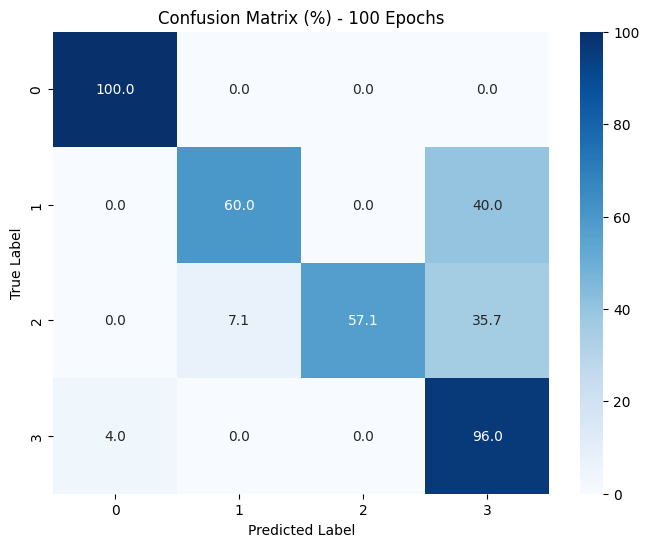

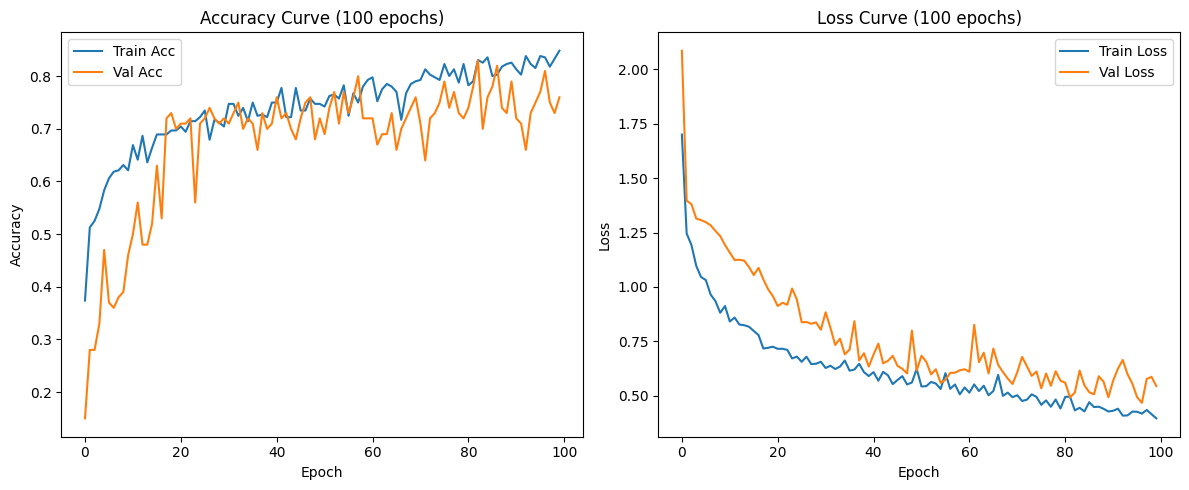

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 Training EXTREME CNN with 150 epochs...
Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.3863 - loss: 1.5076

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 552ms/step - accuracy: 0.3872 - loss: 1.5030 - val_accuracy: 0.2800 - val_loss: 1.5509
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4930 - loss: 1.1948 - val_accuracy: 0.2800 - val_loss: 1.8437
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5517 - loss: 1.1197 - val_accuracy: 0.2800 - val_loss: 1.5437
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5822 - loss: 1.0364

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5816 - loss: 1.0375 - val_accuracy: 0.3000 - val_loss: 1.4434
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5534 - loss: 1.0789 - val_accuracy: 0.3000 - val_loss: 1.3186
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5851 - loss: 0.9682

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5851 - loss: 0.9687 - val_accuracy: 0.3700 - val_loss: 1.2782
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6049 - loss: 0.9782

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6039 - loss: 0.9795 - val_accuracy: 0.4000 - val_loss: 1.2587
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6514 - loss: 0.8949

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6509 - loss: 0.8945 - val_accuracy: 0.4600 - val_loss: 1.2101
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6275 - loss: 0.9780 - val_accuracy: 0.3800 - val_loss: 1.2037
Epoch 10/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6371 - loss: 0.9117

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6373 - loss: 0.9102 - val_accuracy: 0.5400 - val_loss: 1.1379
Epoch 11/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6993 - loss: 0.7738 - val_accuracy: 0.4900 - val_loss: 1.1309
Epoch 12/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6816 - loss: 0.7845

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6827 - loss: 0.7846 - val_accuracy: 0.5500 - val_loss: 1.0841
Epoch 13/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6907 - loss: 0.8224

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6898 - loss: 0.8223 - val_accuracy: 0.7100 - val_loss: 1.0403
Epoch 14/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7249 - loss: 0.7329 - val_accuracy: 0.7100 - val_loss: 1.0012
Epoch 15/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7226 - loss: 0.7347 - val_accuracy: 0.7100 - val_loss: 1.0016
Epoch 16/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7001 - loss: 0.7659 - val_accuracy: 0.6200 - val_loss: 0.9761
Epoch 17/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7061 - loss: 0.7494 - val_accuracy: 0.7100 - val_loss: 0.9162
Epoch 18/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7301 - loss: 0.7254 - val_accuracy: 0.6600 - val_loss: 0.9577
Epoch 19/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7019 - loss: 0.7313 - val_accuracy: 0.6900 - val_loss: 0.9117
Epoch 20/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6714 - loss: 0.7562 - val_accuracy: 0.6300 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7021 - loss: 0.6587 - val_accuracy: 0.7200 - val_loss: 0.8403
Epoch 24/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7550 - loss: 0.6684 - val_accuracy: 0.6900 - val_loss: 0.8562
Epoch 25/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7189 - loss: 0.6800

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7203 - loss: 0.6770 - val_accuracy: 0.7600 - val_loss: 0.8180
Epoch 26/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7272 - loss: 0.6397 - val_accuracy: 0.7500 - val_loss: 0.7736
Epoch 27/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7543 - loss: 0.6433 - val_accuracy: 0.7300 - val_loss: 0.8004
Epoch 28/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7200 - loss: 0.6722 - val_accuracy: 0.7200 - val_loss: 0.8012
Epoch 29/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7381 - loss: 0.5945 - val_accuracy: 0.6500 - val_loss: 0.8215
Epoch 30/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7163 - loss: 0.6648 - val_accuracy: 0.5800 - val_loss: 0.8153
Epoch 31/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6948 - loss: 0.6904 - val_accuracy: 0.6500 - val_loss: 0.7694
Epoch 32/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7009 - loss: 0.7279 - val_accuracy: 0.7200 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7900 - loss: 0.5097 - val_accuracy: 0.8000 - val_loss: 0.5932
Epoch 63/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7798 - loss: 0.5257 - val_accuracy: 0.7400 - val_loss: 0.6345
Epoch 64/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7823 - loss: 0.5211 - val_accuracy: 0.6700 - val_loss: 0.8266
Epoch 65/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7878 - loss: 0.4995 - val_accuracy: 0.6700 - val_loss: 0.7102
Epoch 66/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7587 - loss: 0.5338 - val_accuracy: 0.5900 - val_loss: 0.7361
Epoch 67/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8036 - loss: 0.5142 - val_accuracy: 0.5700 - val_loss: 0.7261
Evaluating CNN trained with 150 epochs...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
📊 Results for 150 epochs:
  Accuracy: 74.00%
  Precision: 0.7557
  Recall: 0.7400
  F1-score: 0.7340

📑 Classification Report:
              precision    reca

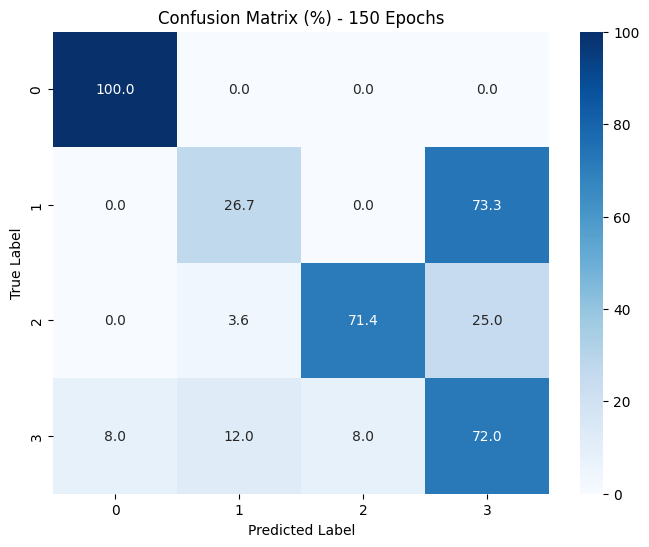

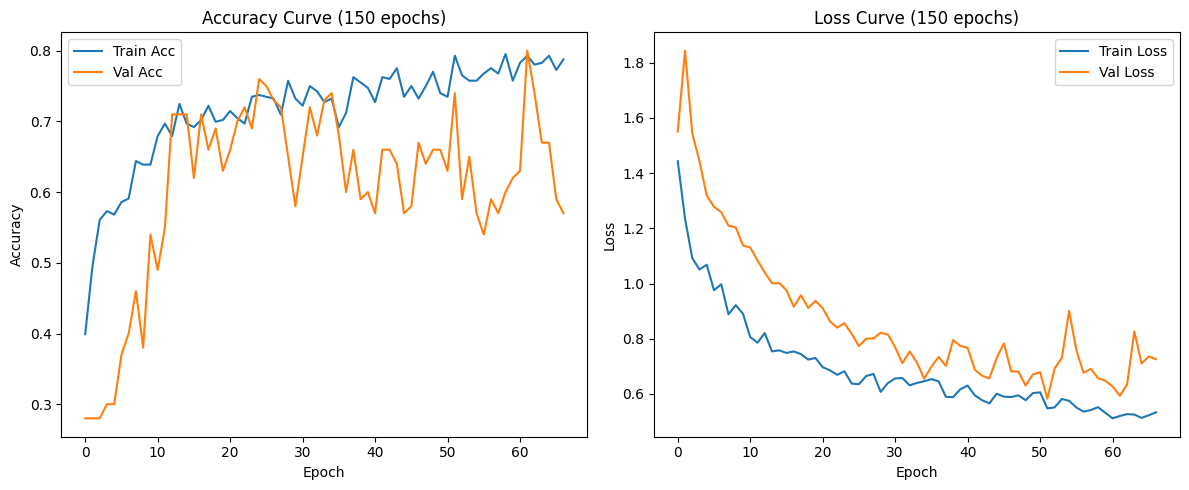

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 Training EXTREME CNN with 200 epochs...
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.3131 - loss: 1.5508

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 536ms/step - accuracy: 0.3186 - loss: 1.5433 - val_accuracy: 0.2800 - val_loss: 2.3342
Epoch 2/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5228 - loss: 1.2325

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5235 - loss: 1.2296 - val_accuracy: 0.2900 - val_loss: 1.5931
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5437 - loss: 1.1324

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5422 - loss: 1.1329 - val_accuracy: 0.3000 - val_loss: 1.5777
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5947 - loss: 1.1055

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5930 - loss: 1.1044 - val_accuracy: 0.3300 - val_loss: 1.5302
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5971 - loss: 0.9596

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5978 - loss: 0.9608 - val_accuracy: 0.3400 - val_loss: 1.3390
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6187 - loss: 0.9114

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6174 - loss: 0.9150 - val_accuracy: 0.4400 - val_loss: 1.2532
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6093 - loss: 1.0009

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6093 - loss: 0.9998 - val_accuracy: 0.5100 - val_loss: 1.2022
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5700 - loss: 0.9896 - val_accuracy: 0.4900 - val_loss: 1.1848
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6608 - loss: 0.9057

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6598 - loss: 0.9069 - val_accuracy: 0.5300 - val_loss: 1.1583
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6890 - loss: 0.7887

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6876 - loss: 0.7911 - val_accuracy: 0.6000 - val_loss: 1.1562
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6781 - loss: 0.8382

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6784 - loss: 0.8368 - val_accuracy: 0.6500 - val_loss: 1.0971
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7112 - loss: 0.7595 - val_accuracy: 0.6100 - val_loss: 1.0980
Epoch 13/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6634 - loss: 0.7870 - val_accuracy: 0.6500 - val_loss: 1.0727
Epoch 14/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6912 - loss: 0.7895

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6918 - loss: 0.7874 - val_accuracy: 0.6800 - val_loss: 1.0551
Epoch 15/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7036 - loss: 0.7608 - val_accuracy: 0.6800 - val_loss: 1.0235
Epoch 16/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6883 - loss: 0.7580 - val_accuracy: 0.6800 - val_loss: 0.9988
Epoch 17/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7140 - loss: 0.7443 - val_accuracy: 0.6000 - val_loss: 1.0158
Epoch 18/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6575 - loss: 0.7623

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6614 - loss: 0.7585 - val_accuracy: 0.7100 - val_loss: 0.9499
Epoch 19/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6723 - loss: 0.7523 - val_accuracy: 0.6600 - val_loss: 0.9506
Epoch 20/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6577 - loss: 0.7578 - val_accuracy: 0.5700 - val_loss: 0.9784
Epoch 21/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7641 - loss: 0.6557 - val_accuracy: 0.6700 - val_loss: 0.8941
Epoch 22/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6686 - loss: 0.6962 - val_accuracy: 0.6100 - val_loss: 0.9200
Epoch 23/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7019 - loss: 0.6888 - val_accuracy: 0.6700 - val_loss: 0.8759
Epoch 24/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6827 - loss: 0.7068 - val_accuracy: 0.6400 - val_loss: 0.8918
Epoch 25/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7248 - loss: 0.6519 - val_accuracy: 0.6500 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7719 - loss: 0.5493 - val_accuracy: 0.7300 - val_loss: 0.6268
Epoch 58/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8093 - loss: 0.4958 - val_accuracy: 0.7200 - val_loss: 0.6226
Epoch 59/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7815 - loss: 0.5405 - val_accuracy: 0.6900 - val_loss: 0.7080
Epoch 60/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7990 - loss: 0.4796 - val_accuracy: 0.7200 - val_loss: 0.6644
Epoch 61/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7714 - loss: 0.5183 - val_accuracy: 0.6700 - val_loss: 0.7072
Epoch 62/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7742 - loss: 0.5489 - val_accuracy: 0.6300 - val_loss: 0.7344
Epoch 63/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7677 - loss: 0.5489 - val_accuracy: 0.6100 - val_loss: 0.9097
Epoch 64/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8313 - loss: 0.4501 - val_accuracy: 0.5700 

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
📊 Results for 200 epochs:
  Accuracy: 72.00%
  Precision: 0.7945
  Recall: 0.7200
  F1-score: 0.7046

📑 Classification Report:
              precision    recall  f1-score   support

           0     0.8421    1.0000    0.9143        32
           1     0.8000    0.2667    0.4000        15
           2     1.0000    0.5357    0.6977        28
           3     0.5000    0.8400    0.6269        25

    accuracy                         0.7200       100
   macro avg     0.7855    0.6606    0.6597       100
weighted avg     0.7945    0.7200    0.7046       100



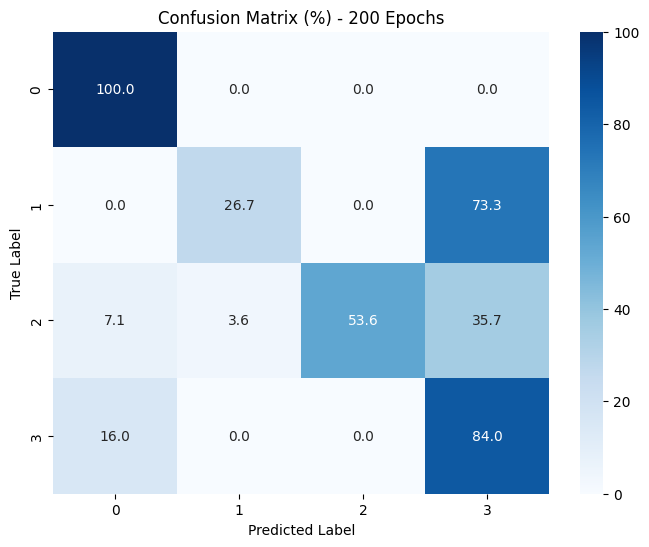

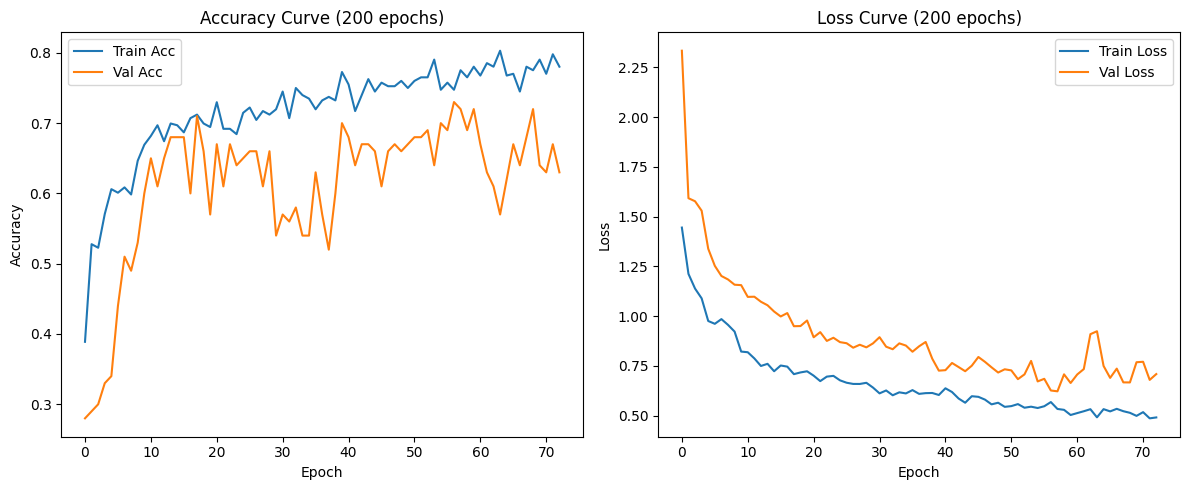

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🚀 Training EXTREME CNN with 250 epochs...
Epoch 1/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.3919 - loss: 1.4262

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 619ms/step - accuracy: 0.3949 - loss: 1.4208 - val_accuracy: 0.2800 - val_loss: 1.5961
Epoch 2/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5083 - loss: 1.1656 - val_accuracy: 0.2700 - val_loss: 1.5351
Epoch 3/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5261 - loss: 1.1175 - val_accuracy: 0.2800 - val_loss: 1.3757
Epoch 4/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5057 - loss: 1.0941

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5077 - loss: 1.0920 - val_accuracy: 0.3100 - val_loss: 1.3182
Epoch 5/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6161 - loss: 1.0498

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6154 - loss: 1.0477 - val_accuracy: 0.3700 - val_loss: 1.2656
Epoch 6/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6315 - loss: 0.9315

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6312 - loss: 0.9316 - val_accuracy: 0.4400 - val_loss: 1.2485
Epoch 7/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6729 - loss: 0.8898

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6710 - loss: 0.8911 - val_accuracy: 0.6400 - val_loss: 1.2371
Epoch 8/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6208 - loss: 0.8713 - val_accuracy: 0.4600 - val_loss: 1.2307
Epoch 9/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6699 - loss: 0.8635 - val_accuracy: 0.5900 - val_loss: 1.1742
Epoch 10/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6630 - loss: 0.8397 - val_accuracy: 0.6200 - val_loss: 1.1420
Epoch 11/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6604 - loss: 0.8049

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6620 - loss: 0.8045 - val_accuracy: 0.6500 - val_loss: 1.1017
Epoch 12/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6425 - loss: 0.8267

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6424 - loss: 0.8268 - val_accuracy: 0.7100 - val_loss: 1.0893
Epoch 13/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6826 - loss: 0.7655 - val_accuracy: 0.5700 - val_loss: 1.0816
Epoch 14/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6790 - loss: 0.7602 - val_accuracy: 0.5600 - val_loss: 1.0541
Epoch 15/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6972 - loss: 0.7335 - val_accuracy: 0.6400 - val_loss: 1.0221
Epoch 16/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6796 - loss: 0.7935

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6806 - loss: 0.7902 - val_accuracy: 0.7300 - val_loss: 0.9818
Epoch 17/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7021 - loss: 0.7619 - val_accuracy: 0.5900 - val_loss: 0.9737
Epoch 18/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6928 - loss: 0.7178 - val_accuracy: 0.6100 - val_loss: 0.9755
Epoch 19/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7092 - loss: 0.7031 - val_accuracy: 0.6200 - val_loss: 0.9575
Epoch 20/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6486 - loss: 0.7705 - val_accuracy: 0.5900 - val_loss: 0.9320
Epoch 21/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6736 - loss: 0.7461 - val_accuracy: 0.5700 - val_loss: 0.9833
Epoch 22/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6938 - loss: 0.7202 - val_accuracy: 0.7200 - val_loss: 0.8276
Epoch 23/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7066 - loss: 0.6786 - val_accuracy: 0.6100 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7261 - loss: 0.6792 - val_accuracy: 0.7400 - val_loss: 0.7910
Epoch 27/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7332 - loss: 0.6495 - val_accuracy: 0.7200 - val_loss: 0.7656
Epoch 28/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7192 - loss: 0.6578 - val_accuracy: 0.7300 - val_loss: 0.7264
Epoch 29/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7004 - loss: 0.6902 - val_accuracy: 0.6400 - val_loss: 0.8665
Epoch 30/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7331 - loss: 0.6655 - val_accuracy: 0.7400 - val_loss: 0.7434
Epoch 31/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6823 - loss: 0.7282 - val_accuracy: 0.7200 - val_loss: 0.7132
Epoch 32/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7743 - loss: 0.5982 - val_accuracy: 0.7400 - val_loss: 0.7162
Epoch 33/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6809 - loss: 0.6514 - val_accuracy: 0.7200 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7484 - loss: 0.6340 - val_accuracy: 0.7500 - val_loss: 0.7189
Epoch 36/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7526 - loss: 0.6084 - val_accuracy: 0.7200 - val_loss: 0.7017
Epoch 37/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7100 - loss: 0.6735 - val_accuracy: 0.7400 - val_loss: 0.6726
Epoch 38/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7410 - loss: 0.6702 - val_accuracy: 0.6900 - val_loss: 0.7314
Epoch 39/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7455 - loss: 0.5785 - val_accuracy: 0.7400 - val_loss: 0.6728
Epoch 40/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7747 - loss: 0.5353 - val_accuracy: 0.6800 - val_loss: 0.7249
Epoch 41/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7859 - loss: 0.5704 - val_accuracy: 0.7200 - val_loss: 0.6817
Epoch 42/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7133 - loss: 0.5939 - val_accuracy: 0.6600 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7935 - loss: 0.5502 - val_accuracy: 0.7700 - val_loss: 0.6450
Epoch 55/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7604 - loss: 0.5795 - val_accuracy: 0.6800 - val_loss: 0.7589
Epoch 56/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7657 - loss: 0.5650 - val_accuracy: 0.7200 - val_loss: 0.6653
Epoch 57/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7813 - loss: 0.5227 - val_accuracy: 0.6900 - val_loss: 0.7303
Epoch 58/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7775 - loss: 0.5308 - val_accuracy: 0.7000 - val_loss: 0.7157
Epoch 59/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7839 - loss: 0.5127 - val_accuracy: 0.6600 - val_loss: 0.7983
Epoch 60/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8111 - loss: 0.5005 - val_accuracy: 0.6400 - val_loss: 0.8329
Epoch 61/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7652 - loss: 0.5459 - val_accuracy: 0.7200 

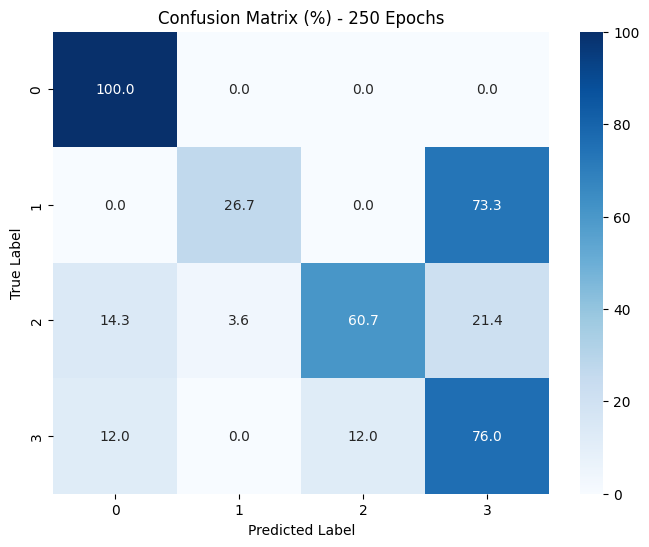

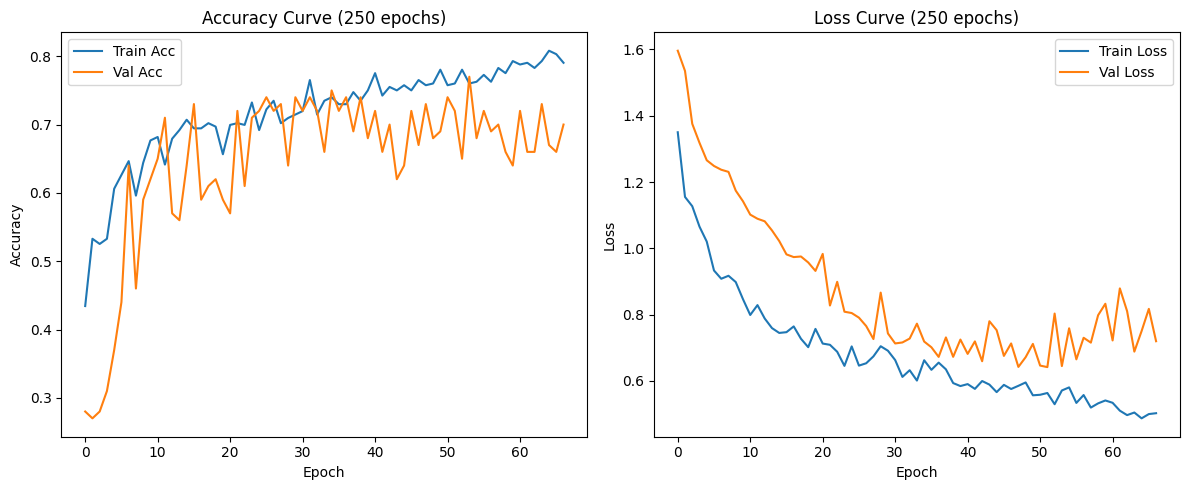


✅ Extreme CNN training complete.

📊 Final Results Summary Table:
     accuracy  precision  recall        f1
100      0.81   0.863030    0.81  0.807175
150      0.74   0.755722    0.74  0.734018
200      0.72   0.794474    0.72  0.704637
250      0.72   0.752509    0.72  0.702522


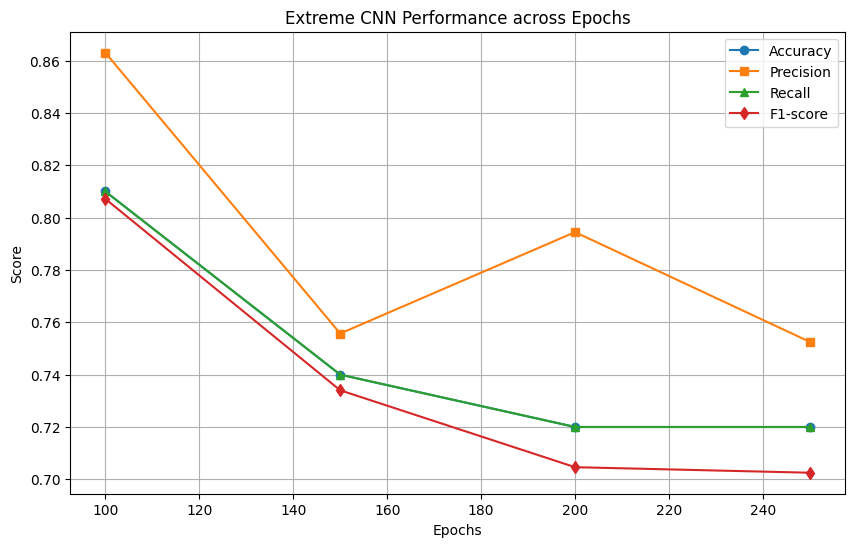

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the epoch values to iterate through
epochs_list = [100, 150, 200, 250]
# epochs_list = [10]

if X_train is not None and y_train is not None and X_test is not None and y_test is not None:

    num_classes = len(np.unique(y_train))
    results = {}  # store results for each epoch model

    for epochs in epochs_list:
        print(f"\n🚀 Training EXTREME CNN with {epochs} epochs...")

        # Extreme CNN architecture
        model_cnn = Sequential([
            Conv2D(64, (3, 3), activation='relu', padding='same',
                   input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.3),

            Conv2D(256, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.4),

            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        # Compile with smaller learning rate
        optimizer = Adam(learning_rate=1e-4)
        model_cnn.compile(optimizer=optimizer,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        mc = ModelCheckpoint(f'cnn_best_model_{epochs}.h5',
                             monitor='val_accuracy', save_best_only=True)

        # Train model
        history = model_cnn.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[es, mc],
            batch_size=32,
            verbose=1
        )

        # Evaluate model
        print(f"Evaluating CNN trained with {epochs} epochs...")
        loss, accuracy = model_cnn.evaluate(X_test, y_test, verbose=0)

        # Predictions
        y_pred_probs = model_cnn.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Metrics
        precision = precision_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)

        print(f"📊 Results for {epochs} epochs:")
        print(f"  Accuracy: {accuracy * 100:.2f}%")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")

        # Classification report
        print("\n📑 Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # Confusion Matrix (percentage)
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        plt.figure(figsize=(8,6))
        sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues",
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f"Confusion Matrix (%) - {epochs} Epochs")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        # Accuracy & Loss curves
        plt.figure(figsize=(12,5))
        # Accuracy plot
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'Accuracy Curve ({epochs} epochs)')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Loss Curve ({epochs} epochs)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Save results
        results[epochs] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

        # Save the trained model
        model_cnn.save(f"cnn_model_{epochs}.h5")

    print("\n✅ Extreme CNN training complete.")

    # Summary Table
    results_df = pd.DataFrame.from_dict(results, orient='index')
    print("\n📊 Final Results Summary Table:")
    print(results_df)

    # Plot comparison graph across epoch settings
    plt.figure(figsize=(10,6))
    plt.plot(results_df.index, results_df['accuracy'], marker='o', label='Accuracy')
    plt.plot(results_df.index, results_df['precision'], marker='s', label='Precision')
    plt.plot(results_df.index, results_df['recall'], marker='^', label='Recall')
    plt.plot(results_df.index, results_df['f1'], marker='d', label='F1-score')

    plt.title("Extreme CNN Performance across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\n⚠ Data is not ready. Please check preprocessing.")


# **LSTM**
1.  Epochs 150: Acc=0.7000, Precision=0.7057, Recall=0.7000, F1=0.6969


🚀 Training Extreme LSTM with 100 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3538 - loss: 1.5005

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.3526 - loss: 1.5008 - val_accuracy: 0.3300 - val_loss: 1.3809
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2903 - loss: 1.5305

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2910 - loss: 1.5307 - val_accuracy: 0.3400 - val_loss: 1.3678
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3944 - loss: 1.3860 - val_accuracy: 0.3100 - val_loss: 1.3561
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4034 - loss: 1.2956 - val_accuracy: 0.3000 - val_loss: 1.3478
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4406 - loss: 1.2907 - val_accuracy: 0.3400 - val_loss: 1.3421
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4213 - loss: 1.3210

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4220 - loss: 1.3181 - val_accuracy: 0.3600 - val_loss: 1.3418
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4348 - loss: 1.3417

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4337 - loss: 1.3392 - val_accuracy: 0.3700 - val_loss: 1.3273
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4432 - loss: 1.2605 - val_accuracy: 0.3600 - val_loss: 1.3106
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5023 - loss: 1.1861

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4995 - loss: 1.1911 - val_accuracy: 0.4500 - val_loss: 1.2839
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5088 - loss: 1.2044 - val_accuracy: 0.4200 - val_loss: 1.2721
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4768 - loss: 1.1273 - val_accuracy: 0.4200 - val_loss: 1.2407
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5548 - loss: 1.0376

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5520 - loss: 1.0412 - val_accuracy: 0.4700 - val_loss: 1.2178
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5116 - loss: 1.0709 - val_accuracy: 0.4400 - val_loss: 1.2130
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4884 - loss: 1.2148

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4916 - loss: 1.2095 - val_accuracy: 0.5200 - val_loss: 1.1865
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5249 - loss: 1.0550 - val_accuracy: 0.3700 - val_loss: 1.2328
Epoch 16/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5313 - loss: 1.1246 - val_accuracy: 0.3600 - val_loss: 1.3259
Epoch 17/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4932 - loss: 1.0721 - val_accuracy: 0.3700 - val_loss: 1.2448
Epoch 18/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5099 - loss: 1.0734 - val_accuracy: 0.4200 - val_loss: 1.1725
Epoch 19/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5215 - loss: 1.0927 - val_accuracy: 0.3200 - val_loss: 1.3458
Epoch 20/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5323 - loss: 1.0580 - val_accuracy: 0.3700 - val_loss: 1.2310
Epoch 21/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5165 - loss: 1.0911 - val_accuracy: 0.3800 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5408 - loss: 1.0672 - val_accuracy: 0.6700 - val_loss: 0.9843
Epoch 26/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5779 - loss: 1.0632 - val_accuracy: 0.4000 - val_loss: 1.3102
Epoch 27/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5510 - loss: 0.9987 - val_accuracy: 0.3500 - val_loss: 1.3934
Epoch 28/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5481 - loss: 1.0303 - val_accuracy: 0.4500 - val_loss: 1.1114
Epoch 29/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6129 - loss: 1.0124 - val_accuracy: 0.4800 - val_loss: 1.0844
Epoch 30/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6082 - loss: 0.9359 - val_accuracy: 0.5500 - val_loss: 1.0456
Epoch 31/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6184 - loss: 0.9500 - val_accuracy: 0.5100 - val_loss: 1.0398
Epoch 32/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6342 - loss: 0.9208 - val_accuracy: 0.6500 

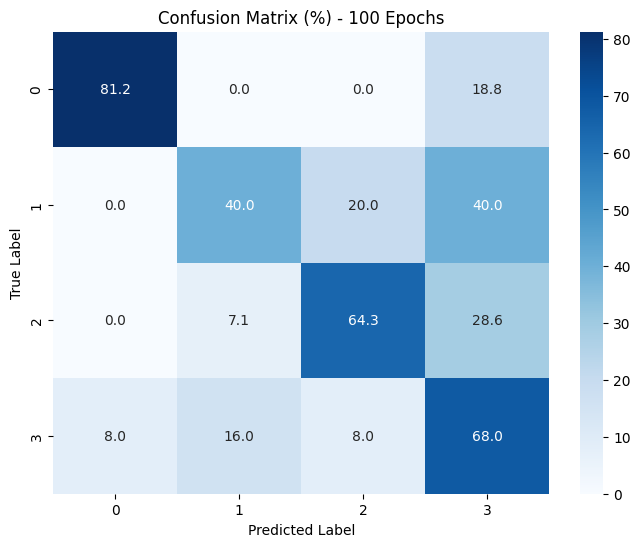

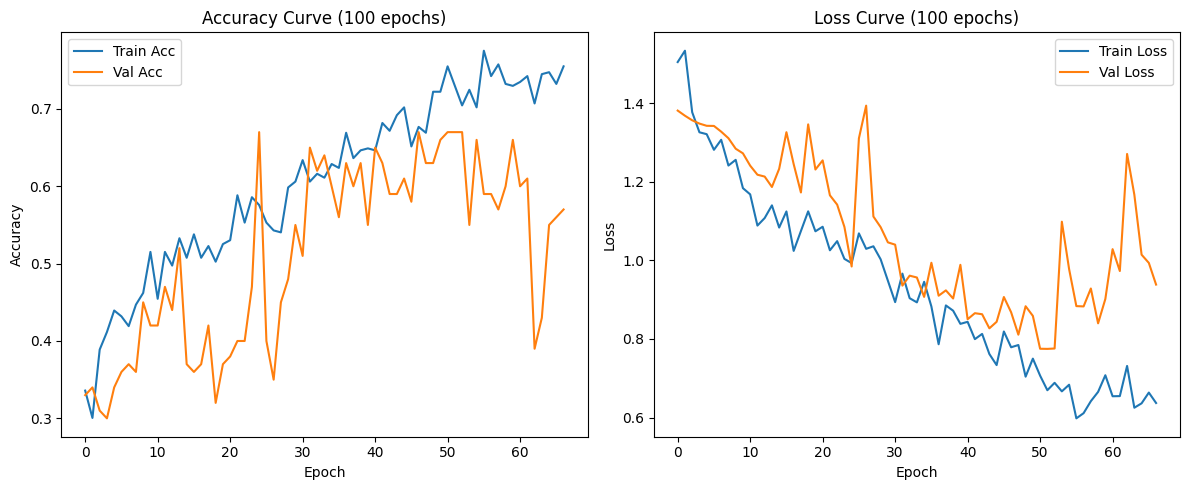


🚀 Training Extreme LSTM with 150 epochs...
Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2428 - loss: 1.7077

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.2381 - loss: 1.7086 - val_accuracy: 0.3700 - val_loss: 1.3561
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2987 - loss: 1.5055

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2979 - loss: 1.5050 - val_accuracy: 0.4000 - val_loss: 1.3478
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2563 - loss: 1.5398 - val_accuracy: 0.4000 - val_loss: 1.3320
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3649 - loss: 1.4375

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3642 - loss: 1.4368 - val_accuracy: 0.4700 - val_loss: 1.3183
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3876 - loss: 1.4347

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3873 - loss: 1.4310 - val_accuracy: 0.5000 - val_loss: 1.3024
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3925 - loss: 1.3825 - val_accuracy: 0.4700 - val_loss: 1.2821
Epoch 7/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4641 - loss: 1.2792

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4653 - loss: 1.2709 - val_accuracy: 0.5800 - val_loss: 1.2757
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4243 - loss: 1.3537

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4235 - loss: 1.3517 - val_accuracy: 0.6000 - val_loss: 1.2582
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4956 - loss: 1.1677 - val_accuracy: 0.5300 - val_loss: 1.2276
Epoch 10/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3897 - loss: 1.2864 - val_accuracy: 0.5800 - val_loss: 1.2041
Epoch 11/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4620 - loss: 1.2196 - val_accuracy: 0.5900 - val_loss: 1.1770
Epoch 12/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4433 - loss: 1.1998 - val_accuracy: 0.6000 - val_loss: 1.1727
Epoch 13/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5079 - loss: 1.0966

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5064 - loss: 1.1043 - val_accuracy: 0.6100 - val_loss: 1.1453
Epoch 14/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5323 - loss: 1.1015 - val_accuracy: 0.5900 - val_loss: 1.1468
Epoch 15/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5085 - loss: 1.0888 - val_accuracy: 0.6100 - val_loss: 1.0887
Epoch 16/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5187 - loss: 1.0864

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5185 - loss: 1.0882 - val_accuracy: 0.6300 - val_loss: 1.0617
Epoch 17/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4919 - loss: 1.1129 - val_accuracy: 0.5000 - val_loss: 1.1621
Epoch 18/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4989 - loss: 1.1290 - val_accuracy: 0.5600 - val_loss: 1.1091
Epoch 19/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5235 - loss: 1.1050 - val_accuracy: 0.5100 - val_loss: 1.1430
Epoch 20/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5538 - loss: 1.0695 - val_accuracy: 0.5800 - val_loss: 1.0814
Epoch 21/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5276 - loss: 1.0607 - val_accuracy: 0.4800 - val_loss: 1.1097
Epoch 22/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5523 - loss: 1.0139 - val_accuracy: 0.5700 - val_loss: 1.0533
Epoch 23/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5693 - loss: 0.9795 - val_accuracy: 0.4500 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6086 - loss: 0.9474 - val_accuracy: 0.6600 - val_loss: 0.8711
Epoch 40/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5965 - loss: 0.9073 - val_accuracy: 0.5500 - val_loss: 1.0722
Epoch 41/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5864 - loss: 0.9014

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5882 - loss: 0.9017 - val_accuracy: 0.6700 - val_loss: 0.8831
Epoch 42/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6038 - loss: 0.9278 - val_accuracy: 0.6100 - val_loss: 0.9977
Epoch 43/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6262 - loss: 0.8686 - val_accuracy: 0.6500 - val_loss: 0.9417
Epoch 44/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6052 - loss: 0.8886 - val_accuracy: 0.6600 - val_loss: 0.8947
Epoch 45/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5799 - loss: 0.8747

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5821 - loss: 0.8754 - val_accuracy: 0.6900 - val_loss: 0.7923
Epoch 46/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6317 - loss: 0.8324 - val_accuracy: 0.6400 - val_loss: 0.8235
Epoch 47/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6254 - loss: 0.8241 - val_accuracy: 0.6600 - val_loss: 0.8745
Epoch 48/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6130 - loss: 0.8884 - val_accuracy: 0.6300 - val_loss: 0.8549
Epoch 49/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6150 - loss: 0.8715 - val_accuracy: 0.5900 - val_loss: 0.8967
Epoch 50/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6580 - loss: 0.7998 - val_accuracy: 0.6400 - val_loss: 0.8651
Epoch 51/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5885 - loss: 0.9147 - val_accuracy: 0.6400 - val_loss: 0.8664
Epoch 52/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5889 - loss: 0.9536 - val_accuracy: 0.6200 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6695 - loss: 0.7680 - val_accuracy: 0.7100 - val_loss: 0.7840
Epoch 58/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7205 - loss: 0.7156 - val_accuracy: 0.6600 - val_loss: 0.8329
Epoch 59/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6882 - loss: 0.7795

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6872 - loss: 0.7808 - val_accuracy: 0.7300 - val_loss: 0.7531
Epoch 60/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6776 - loss: 0.7613 - val_accuracy: 0.6900 - val_loss: 0.7725
Epoch 61/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7064 - loss: 0.7563 - val_accuracy: 0.7000 - val_loss: 0.7991
Epoch 62/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6725 - loss: 0.7883 - val_accuracy: 0.7200 - val_loss: 0.7540
Epoch 63/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7276 - loss: 0.6643 - val_accuracy: 0.6600 - val_loss: 0.8378
Epoch 64/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6902 - loss: 0.6890 - val_accuracy: 0.7000 - val_loss: 0.7817
Epoch 65/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6699 - loss: 0.7858

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6702 - loss: 0.7863 - val_accuracy: 0.7500 - val_loss: 0.7460
Epoch 66/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6976 - loss: 0.7201 - val_accuracy: 0.6700 - val_loss: 0.8461
Epoch 67/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6593 - loss: 0.8259 - val_accuracy: 0.6500 - val_loss: 0.8644
Epoch 68/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6923 - loss: 0.7406 - val_accuracy: 0.6100 - val_loss: 0.9974
Epoch 69/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6579 - loss: 0.7914 - val_accuracy: 0.6200 - val_loss: 1.0529
Epoch 70/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7589 - loss: 0.6128 - val_accuracy: 0.6900 - val_loss: 0.7524
Epoch 71/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7760 - loss: 0.6195 - val_accuracy: 0.6900 - val_loss: 0.8343
Epoch 72/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6414 - loss: 0.7319 - val_accuracy: 0.6600 

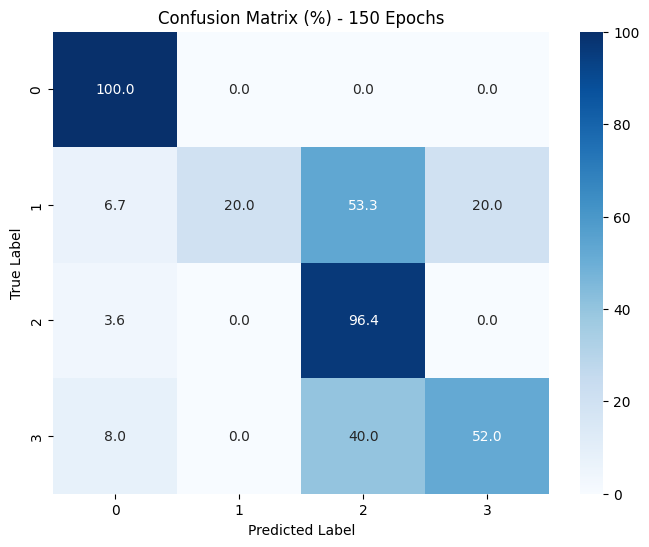

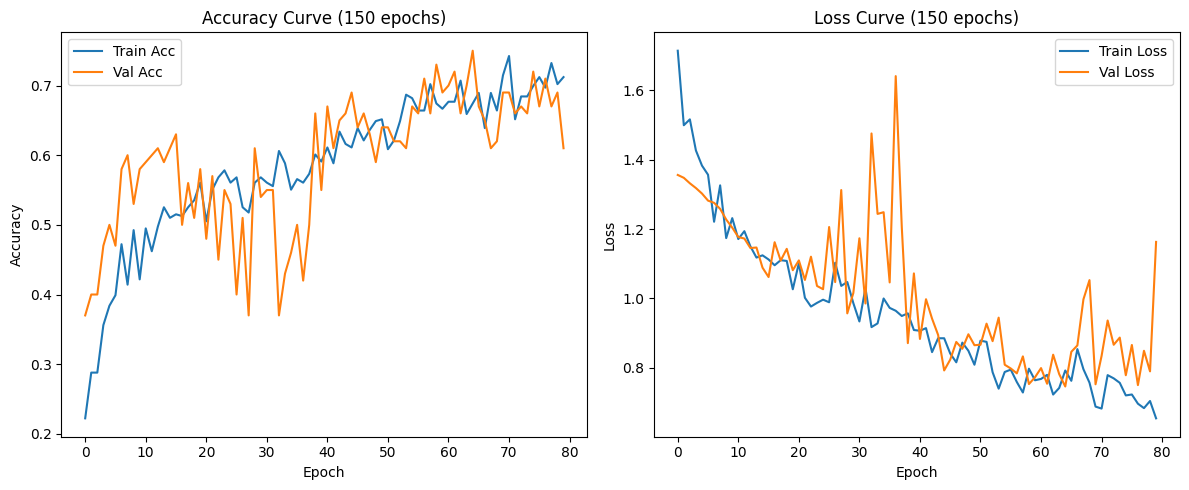


🚀 Training Extreme LSTM with 200 epochs...
Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2666 - loss: 1.8043

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.2592 - loss: 1.8108 - val_accuracy: 0.2900 - val_loss: 1.4093
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3521 - loss: 1.5895 - val_accuracy: 0.2500 - val_loss: 1.3916
Epoch 3/200
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2401 - loss: 1.6654

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2450 - loss: 1.6513 - val_accuracy: 0.3100 - val_loss: 1.3800
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3551 - loss: 1.4810 - val_accuracy: 0.2600 - val_loss: 1.3807
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3351 - loss: 1.5602 - val_accuracy: 0.2600 - val_loss: 1.3555
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3651 - loss: 1.4635 - val_accuracy: 0.2800 - val_loss: 1.3379
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4277 - loss: 1.4087

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4268 - loss: 1.4072 - val_accuracy: 0.3400 - val_loss: 1.3395
Epoch 8/200
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3944 - loss: 1.4606

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4016 - loss: 1.4422 - val_accuracy: 0.3500 - val_loss: 1.3152
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4544 - loss: 1.2938 - val_accuracy: 0.3500 - val_loss: 1.3200
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4124 - loss: 1.3228 - val_accuracy: 0.3500 - val_loss: 1.2950
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4496 - loss: 1.1940

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4494 - loss: 1.1958 - val_accuracy: 0.4000 - val_loss: 1.2822
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5241 - loss: 1.1927 - val_accuracy: 0.3900 - val_loss: 1.2872
Epoch 13/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4674 - loss: 1.2883 - val_accuracy: 0.3800 - val_loss: 1.2664
Epoch 14/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4894 - loss: 1.1994

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4898 - loss: 1.1993 - val_accuracy: 0.4600 - val_loss: 1.2389
Epoch 15/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5106 - loss: 1.1734 - val_accuracy: 0.4500 - val_loss: 1.2148
Epoch 16/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5115 - loss: 1.1497 - val_accuracy: 0.3200 - val_loss: 1.3238
Epoch 17/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5061 - loss: 1.0650 - val_accuracy: 0.3700 - val_loss: 1.2053
Epoch 18/200
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5380 - loss: 1.0765

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5370 - loss: 1.0818 - val_accuracy: 0.4800 - val_loss: 1.1032
Epoch 19/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5473 - loss: 1.0847

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5479 - loss: 1.0844 - val_accuracy: 0.5300 - val_loss: 1.0834
Epoch 20/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5470 - loss: 1.0383 - val_accuracy: 0.5300 - val_loss: 1.0645
Epoch 21/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5631 - loss: 1.0053 - val_accuracy: 0.5100 - val_loss: 1.1018
Epoch 22/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5486 - loss: 1.0406 - val_accuracy: 0.5000 - val_loss: 1.0864
Epoch 23/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6075 - loss: 0.9795

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6060 - loss: 0.9817 - val_accuracy: 0.6500 - val_loss: 0.9882
Epoch 24/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5112 - loss: 1.1252 - val_accuracy: 0.5200 - val_loss: 1.0659
Epoch 25/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5856 - loss: 1.0267 - val_accuracy: 0.5500 - val_loss: 1.0242
Epoch 26/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5466 - loss: 1.0703 - val_accuracy: 0.5200 - val_loss: 1.0745
Epoch 27/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5781 - loss: 0.9867 - val_accuracy: 0.5300 - val_loss: 1.1794
Epoch 28/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5948 - loss: 0.9244 - val_accuracy: 0.4900 - val_loss: 1.1509
Epoch 29/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5874 - loss: 1.0468 - val_accuracy: 0.4800 - val_loss: 1.1866
Epoch 30/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5881 - loss: 0.9527 - val_accuracy: 0.5400 

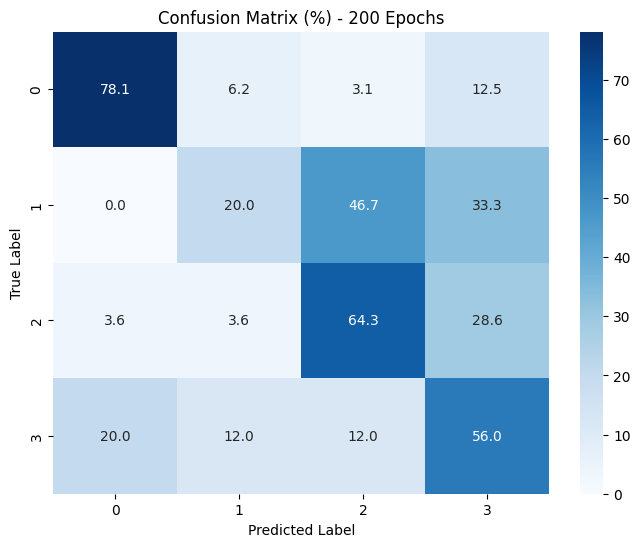

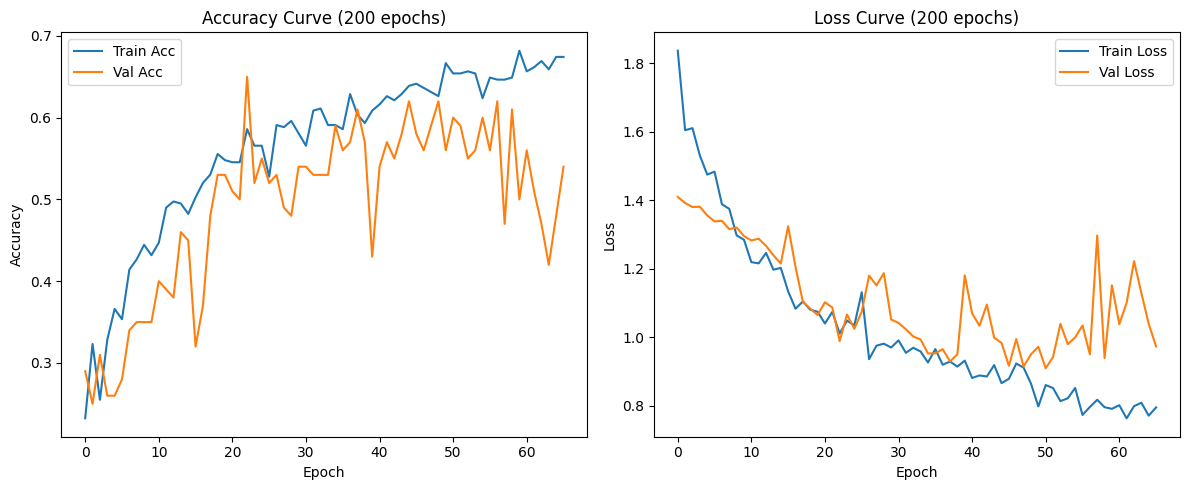

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



🚀 Training Extreme LSTM with 250 epochs...
Epoch 1/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3582 - loss: 1.6155

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.3517 - loss: 1.6188 - val_accuracy: 0.2100 - val_loss: 1.3909
Epoch 2/250
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3154 - loss: 1.5821

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3212 - loss: 1.5692 - val_accuracy: 0.2700 - val_loss: 1.3784
Epoch 3/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3347 - loss: 1.4171 - val_accuracy: 0.2700 - val_loss: 1.3664
Epoch 4/250
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3680 - loss: 1.3983

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3645 - loss: 1.3970 - val_accuracy: 0.3200 - val_loss: 1.3586
Epoch 5/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3956 - loss: 1.3411 - val_accuracy: 0.3200 - val_loss: 1.3518
Epoch 6/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4257 - loss: 1.3038

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4212 - loss: 1.3055 - val_accuracy: 0.4000 - val_loss: 1.3389
Epoch 7/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4094 - loss: 1.2699 - val_accuracy: 0.3700 - val_loss: 1.3202
Epoch 8/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4486 - loss: 1.1916 - val_accuracy: 0.3700 - val_loss: 1.3037
Epoch 9/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4328 - loss: 1.2585 - val_accuracy: 0.3900 - val_loss: 1.2971
Epoch 10/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4491 - loss: 1.2362

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4495 - loss: 1.2361 - val_accuracy: 0.4600 - val_loss: 1.2932
Epoch 11/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5060 - loss: 1.1650

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5015 - loss: 1.1644 - val_accuracy: 0.4800 - val_loss: 1.2742
Epoch 12/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4502 - loss: 1.2260

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4501 - loss: 1.2263 - val_accuracy: 0.5200 - val_loss: 1.2584
Epoch 13/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4597 - loss: 1.2298 - val_accuracy: 0.4300 - val_loss: 1.2364
Epoch 14/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5045 - loss: 1.0918 - val_accuracy: 0.4400 - val_loss: 1.2361
Epoch 15/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4197 - loss: 1.2614 - val_accuracy: 0.5000 - val_loss: 1.2006
Epoch 16/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4987 - loss: 1.1500 - val_accuracy: 0.3500 - val_loss: 1.2252
Epoch 17/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5019 - loss: 1.1514 - val_accuracy: 0.4900 - val_loss: 1.1739
Epoch 18/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4551 - loss: 1.1483 - val_accuracy: 0.4500 - val_loss: 1.1671
Epoch 19/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5228 - loss: 1.1068 - val_accuracy: 0.4700 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5342 - loss: 1.0872 - val_accuracy: 0.5400 - val_loss: 1.0856
Epoch 24/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4706 - loss: 1.1269 - val_accuracy: 0.5200 - val_loss: 1.0821
Epoch 25/250
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4763 - loss: 1.1102

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4829 - loss: 1.1015 - val_accuracy: 0.5500 - val_loss: 1.0593
Epoch 26/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5267 - loss: 1.0860 - val_accuracy: 0.4600 - val_loss: 1.0753
Epoch 27/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5396 - loss: 1.0403 - val_accuracy: 0.5500 - val_loss: 1.0328
Epoch 28/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5677 - loss: 1.0369 - val_accuracy: 0.5100 - val_loss: 1.1110
Epoch 29/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5023 - loss: 1.0988 - val_accuracy: 0.3600 - val_loss: 1.3749
Epoch 30/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5109 - loss: 1.0305 - val_accuracy: 0.3600 - val_loss: 1.2683
Epoch 31/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5453 - loss: 1.0610 - val_accuracy: 0.3600 - val_loss: 1.4583
Epoch 32/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5821 - loss: 1.0204 - val_accuracy: 0.3600 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5767 - loss: 0.9717 - val_accuracy: 0.5700 - val_loss: 0.9966
Epoch 46/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6335 - loss: 0.8437 - val_accuracy: 0.3600 - val_loss: 2.1981
Epoch 47/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5830 - loss: 0.9383 - val_accuracy: 0.3600 - val_loss: 1.7821
Epoch 48/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5837 - loss: 0.9580 - val_accuracy: 0.3600 - val_loss: 2.0357
Epoch 49/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5817 - loss: 1.0257 - val_accuracy: 0.3600 - val_loss: 2.0273
Epoch 50/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5955 - loss: 0.9509 - val_accuracy: 0.3600 - val_loss: 1.8616
Epoch 51/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6070 - loss: 0.9519 - val_accuracy: 0.3600 - val_loss: 2.5228
Epoch 52/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5753 - loss: 0.9505 - val_accuracy: 0.3600 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6050 - loss: 0.8847 - val_accuracy: 0.5900 - val_loss: 0.9817
Epoch 61/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6099 - loss: 0.9065 - val_accuracy: 0.4900 - val_loss: 1.0723
Epoch 62/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6310 - loss: 0.8355 - val_accuracy: 0.4200 - val_loss: 1.1256
Epoch 63/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5686 - loss: 0.9469 - val_accuracy: 0.3600 - val_loss: 2.3635
Epoch 64/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5781 - loss: 0.9700 - val_accuracy: 0.3600 - val_loss: 2.0998
Epoch 65/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5994 - loss: 0.8954 - val_accuracy: 0.3600 - val_loss: 1.9802
Epoch 66/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6363 - loss: 0.8581 - val_accuracy: 0.3600 - val_loss: 1.7609
Epoch 67/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5681 - loss: 0.9257 - val_accuracy: 0.4000 

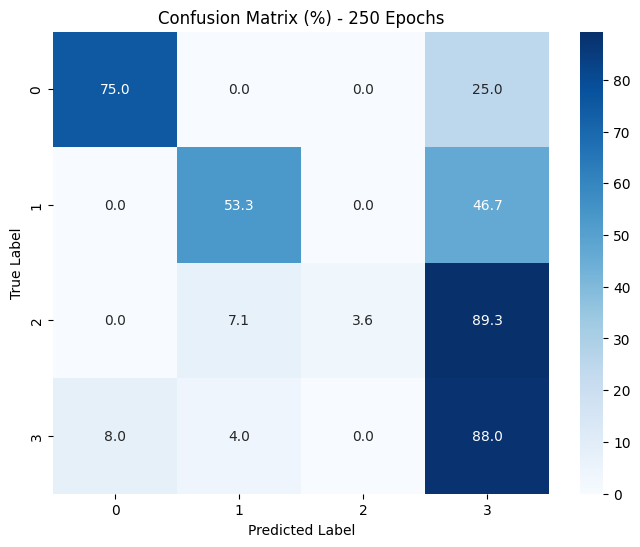

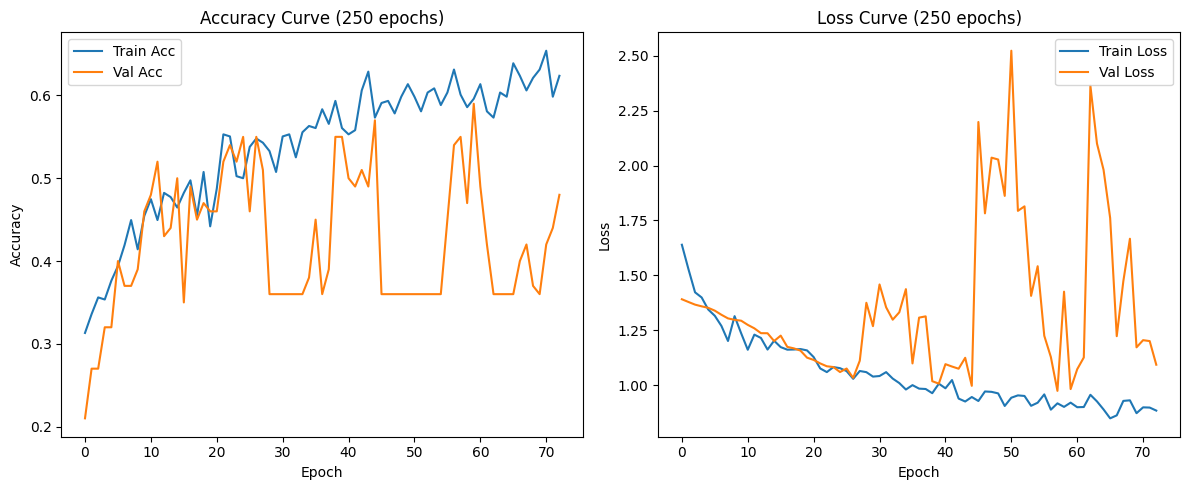


✅ Extreme LSTM training complete.

📊 Final Results Summary Table:
     accuracy  precision  recall        f1
100      0.67   0.706138    0.67  0.678744
150      0.75   0.805569    0.75  0.716836
200      0.60   0.594761    0.60  0.593310
250      0.55   0.773185    0.55  0.502882


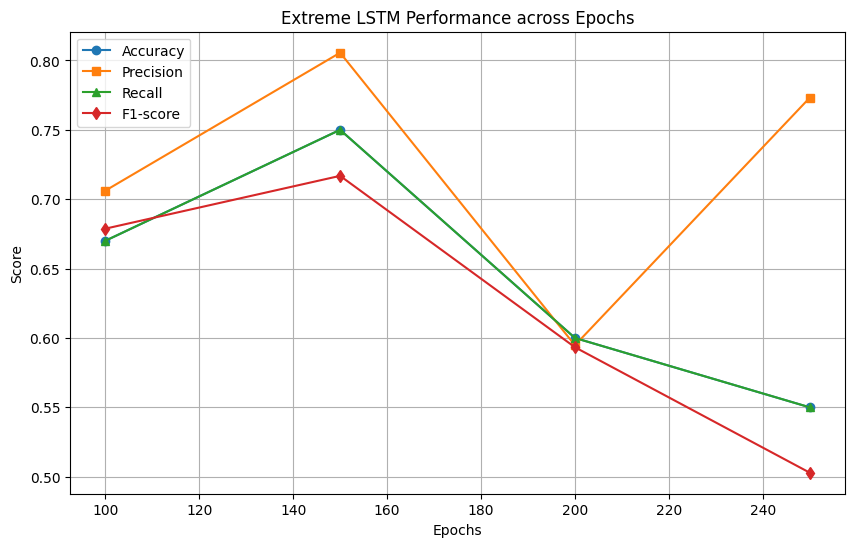

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Epoch values to iterate through
epochs_list = [100, 150, 200, 250]
# epochs_list = [100]

if X_train is not None and y_train is not None and X_test is not None and y_test is not None:

    num_classes = len(np.unique(y_train))
    results = {}

    for epochs in epochs_list:
        print(f"\n🚀 Training Extreme LSTM with {epochs} epochs...")

        # Extreme LSTM architecture
        model_lstm = Sequential([
            LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            BatchNormalization(),
            Dropout(0.3),

            LSTM(64, return_sequences=False),
            BatchNormalization(),
            Dropout(0.4),

            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        # Compile with smaller learning rate
        optimizer = Adam(learning_rate=1e-4)
        model_lstm.compile(optimizer=optimizer,
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        mc = ModelCheckpoint(f'lstm_best_model_{epochs}.h5', monitor='val_accuracy', save_best_only=True)

        # Train model
        history = model_lstm.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[es, mc],
            batch_size=32,
            verbose=1
        )

        # Evaluate model
        print(f"Evaluating LSTM trained with {epochs} epochs...")
        loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose=0)

        # Predictions
        y_pred_probs = model_lstm.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Metrics
        precision = precision_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)

        print(f"📊 Results for {epochs} epochs:")
        print(f"  Accuracy: {accuracy * 100:.2f}%")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")

        # Classification report
        print("\n📑 Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # Confusion Matrix (percentage)
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        plt.figure(figsize=(8,6))
        sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues",
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f"Confusion Matrix (%) - {epochs} Epochs")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        # Accuracy & Loss curves
        plt.figure(figsize=(12,5))
        # Accuracy plot
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'Accuracy Curve ({epochs} epochs)')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Loss Curve ({epochs} epochs)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Save trained model
        model_lstm.save(f"lstm_model_{epochs}.h5")

        # Store results
        results[epochs] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    print("\n✅ Extreme LSTM training complete.")

    # Summary Table
    results_df = pd.DataFrame.from_dict(results, orient='index')
    print("\n📊 Final Results Summary Table:")
    print(results_df)

    # Plot comparison graph across epoch settings
    plt.figure(figsize=(10,6))
    plt.plot(results_df.index, results_df['accuracy'], marker='o', label='Accuracy')
    plt.plot(results_df.index, results_df['precision'], marker='s', label='Precision')
    plt.plot(results_df.index, results_df['recall'], marker='^', label='Recall')
    plt.plot(results_df.index, results_df['f1'], marker='d', label='F1-score')

    plt.title("Extreme LSTM Performance across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\n⚠ Data is not ready. Please check preprocessing.")


# **Bi-LSTM**
1.   Results for 150 epochs
2.   Epochs 150: Acc=0.9400, Precision=0.9402, Recall=0.9400, F1=0.9397



🚀 Training Extreme BiLSTM with 100 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3096 - loss: 1.8451

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3074 - loss: 1.8480 - val_accuracy: 0.3000 - val_loss: 1.3571
Epoch 2/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3852 - loss: 1.6210

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3850 - loss: 1.6248 - val_accuracy: 0.4200 - val_loss: 1.3326
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3930 - loss: 1.6490 - val_accuracy: 0.4000 - val_loss: 1.3096
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3909 - loss: 1.5588 - val_accuracy: 0.3600 - val_loss: 1.2821
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5051 - loss: 1.3690

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5035 - loss: 1.3682 - val_accuracy: 0.4500 - val_loss: 1.2654
Epoch 6/100
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5137 - loss: 1.1984

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5135 - loss: 1.2071 - val_accuracy: 0.4700 - val_loss: 1.2425
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5067 - loss: 1.2217

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5071 - loss: 1.2227 - val_accuracy: 0.4900 - val_loss: 1.2207
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5334 - loss: 1.2318 - val_accuracy: 0.4300 - val_loss: 1.2153
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5292 - loss: 1.1416 - val_accuracy: 0.3800 - val_loss: 1.1970
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5099 - loss: 1.1706 - val_accuracy: 0.4000 - val_loss: 1.1623
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5607 - loss: 1.0602 - val_accuracy: 0.4400 - val_loss: 1.1246
Epoch 12/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5415 - loss: 1.1423

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5399 - loss: 1.1401 - val_accuracy: 0.5300 - val_loss: 1.0841
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6080 - loss: 0.9820 - val_accuracy: 0.4900 - val_loss: 1.0795
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5877 - loss: 0.9875

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5865 - loss: 0.9913 - val_accuracy: 0.5400 - val_loss: 1.0461
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6002 - loss: 0.9583

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5999 - loss: 0.9605 - val_accuracy: 0.5800 - val_loss: 1.0106
Epoch 16/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5422 - loss: 1.0517

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5435 - loss: 1.0497 - val_accuracy: 0.6200 - val_loss: 0.9661
Epoch 17/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6293 - loss: 0.9434

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6289 - loss: 0.9430 - val_accuracy: 0.6300 - val_loss: 0.9476
Epoch 18/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6033 - loss: 0.9816

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6042 - loss: 0.9807 - val_accuracy: 0.6400 - val_loss: 0.9052
Epoch 19/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6730 - loss: 0.8095

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6712 - loss: 0.8134 - val_accuracy: 0.6500 - val_loss: 0.8927
Epoch 20/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6426 - loss: 0.8857 - val_accuracy: 0.5800 - val_loss: 0.9387
Epoch 21/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6160 - loss: 0.9701

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6179 - loss: 0.9633 - val_accuracy: 0.7000 - val_loss: 0.8339
Epoch 22/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6441 - loss: 0.8364

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6466 - loss: 0.8361 - val_accuracy: 0.7100 - val_loss: 0.7809
Epoch 23/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6510 - loss: 0.8335 - val_accuracy: 0.6600 - val_loss: 0.7991
Epoch 24/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6643 - loss: 0.8351 - val_accuracy: 0.6900 - val_loss: 0.7985
Epoch 25/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6187 - loss: 0.8804 - val_accuracy: 0.6900 - val_loss: 0.7724
Epoch 26/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6856 - loss: 0.7629

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6857 - loss: 0.7645 - val_accuracy: 0.7600 - val_loss: 0.7094
Epoch 27/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7060 - loss: 0.6835 - val_accuracy: 0.6700 - val_loss: 0.7128
Epoch 28/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7442 - loss: 0.6788 - val_accuracy: 0.7300 - val_loss: 0.6956
Epoch 29/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7305 - loss: 0.6521 - val_accuracy: 0.7000 - val_loss: 0.6868
Epoch 30/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7210 - loss: 0.7301 - val_accuracy: 0.6600 - val_loss: 0.6610
Epoch 31/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7025 - loss: 0.6745 - val_accuracy: 0.7400 - val_loss: 0.6924
Epoch 32/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7431 - loss: 0.7025 - val_accuracy: 0.7200 - val_loss: 0.6999
Epoch 33/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7641 - loss: 0.6210 - val_accuracy: 0.7200 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7562 - loss: 0.6446 - val_accuracy: 0.7700 - val_loss: 0.6016
Epoch 35/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7439 - loss: 0.6122 - val_accuracy: 0.7400 - val_loss: 0.6789
Epoch 36/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7526 - loss: 0.6175 - val_accuracy: 0.7400 - val_loss: 0.6831
Epoch 37/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7761 - loss: 0.5716 - val_accuracy: 0.6200 - val_loss: 0.8134
Epoch 38/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7934 - loss: 0.5577

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7936 - loss: 0.5585 - val_accuracy: 0.7900 - val_loss: 0.5488
Epoch 39/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7944 - loss: 0.5785

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7936 - loss: 0.5766 - val_accuracy: 0.8000 - val_loss: 0.5467
Epoch 40/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7946 - loss: 0.5383 - val_accuracy: 0.7800 - val_loss: 0.5484
Epoch 41/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8150 - loss: 0.5238 - val_accuracy: 0.7300 - val_loss: 0.6221
Epoch 42/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8155 - loss: 0.5162 - val_accuracy: 0.7900 - val_loss: 0.5641
Epoch 43/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7984 - loss: 0.4822 - val_accuracy: 0.8000 - val_loss: 0.4841
Epoch 44/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7826 - loss: 0.5330

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7827 - loss: 0.5328 - val_accuracy: 0.8500 - val_loss: 0.4568
Epoch 45/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8428 - loss: 0.4309 - val_accuracy: 0.7800 - val_loss: 0.5214
Epoch 46/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8494 - loss: 0.4271

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8464 - loss: 0.4314 - val_accuracy: 0.8600 - val_loss: 0.4578
Epoch 47/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8054 - loss: 0.4660 - val_accuracy: 0.8400 - val_loss: 0.4549
Epoch 48/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7941 - loss: 0.4774 - val_accuracy: 0.8400 - val_loss: 0.4280
Epoch 49/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8288 - loss: 0.4637 - val_accuracy: 0.8200 - val_loss: 0.4339
Epoch 50/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8700 - loss: 0.3827 - val_accuracy: 0.8200 - val_loss: 0.4314
Epoch 51/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8497 - loss: 0.4088 - val_accuracy: 0.7600 - val_loss: 0.5149
Epoch 52/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8327 - loss: 0.4470 - val_accuracy: 0.8000 - val_loss: 0.4781
Epoch 53/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8543 - loss: 0.4625 - val_accuracy: 0.7700 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8788 - loss: 0.3288 - val_accuracy: 0.8800 - val_loss: 0.4262
Epoch 64/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8741 - loss: 0.3453 - val_accuracy: 0.7700 - val_loss: 0.6459
Epoch 65/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9211 - loss: 0.2553 - val_accuracy: 0.8800 - val_loss: 0.3745
Epoch 66/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9065 - loss: 0.2914 - val_accuracy: 0.8200 - val_loss: 0.4367
Epoch 67/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8806 - loss: 0.2908 - val_accuracy: 0.8500 - val_loss: 0.3751
Epoch 68/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8663 - loss: 0.3393 - val_accuracy: 0.8200 - val_loss: 0.5280
Epoch 69/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9077 - loss: 0.2786 - val_accuracy: 0.7600 - val_loss: 0.5874
Epoch 70/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8645 - loss: 0.3251

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8640 - loss: 0.3265 - val_accuracy: 0.8900 - val_loss: 0.3974
Epoch 71/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8628 - loss: 0.3558 - val_accuracy: 0.8900 - val_loss: 0.3471
Epoch 72/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9049 - loss: 0.2725 - val_accuracy: 0.8900 - val_loss: 0.3585
Epoch 73/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9009 - loss: 0.2858 - val_accuracy: 0.8500 - val_loss: 0.3354
Epoch 74/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8840 - loss: 0.2959 - val_accuracy: 0.8700 - val_loss: 0.3326
Epoch 75/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9131 - loss: 0.2414 - val_accuracy: 0.8800 - val_loss: 0.3642
Epoch 76/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8939 - loss: 0.2886 - val_accuracy: 0.8600 - val_loss: 0.3799
Epoch 77/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8783 - loss: 0.3370 - val_accuracy: 0.8900 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9110 - loss: 0.2852 - val_accuracy: 0.9000 - val_loss: 0.3295
Epoch 81/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9237 - loss: 0.2229 - val_accuracy: 0.8900 - val_loss: 0.3178
Epoch 82/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9105 - loss: 0.2671

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9110 - loss: 0.2662 - val_accuracy: 0.9200 - val_loss: 0.3176
Epoch 83/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9311 - loss: 0.2146 - val_accuracy: 0.9100 - val_loss: 0.3077
Epoch 84/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9103 - loss: 0.2762 - val_accuracy: 0.9000 - val_loss: 0.3487
Epoch 85/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9159 - loss: 0.2822 - val_accuracy: 0.8900 - val_loss: 0.3606
Epoch 86/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8858 - loss: 0.2682 - val_accuracy: 0.8800 - val_loss: 0.4082
Epoch 87/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9301 - loss: 0.2275 - val_accuracy: 0.8900 - val_loss: 0.3492
Epoch 88/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9288 - loss: 0.2010 - val_accuracy: 0.8800 - val_loss: 0.4016
Epoch 89/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9379 - loss: 0.2122 - val_accuracy: 0.9100 

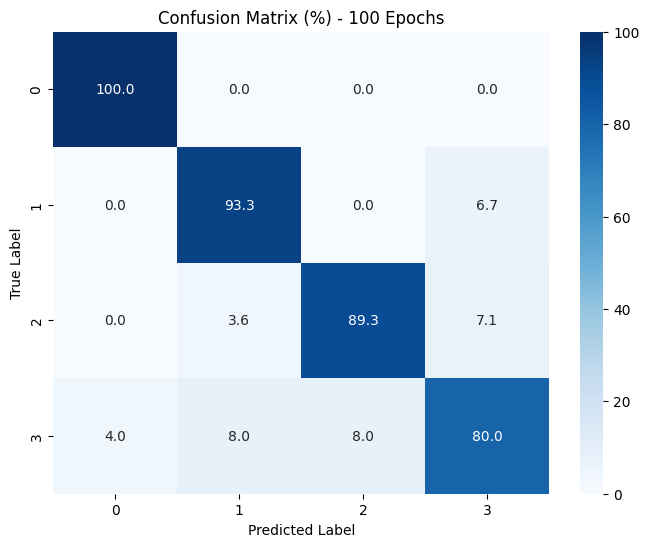

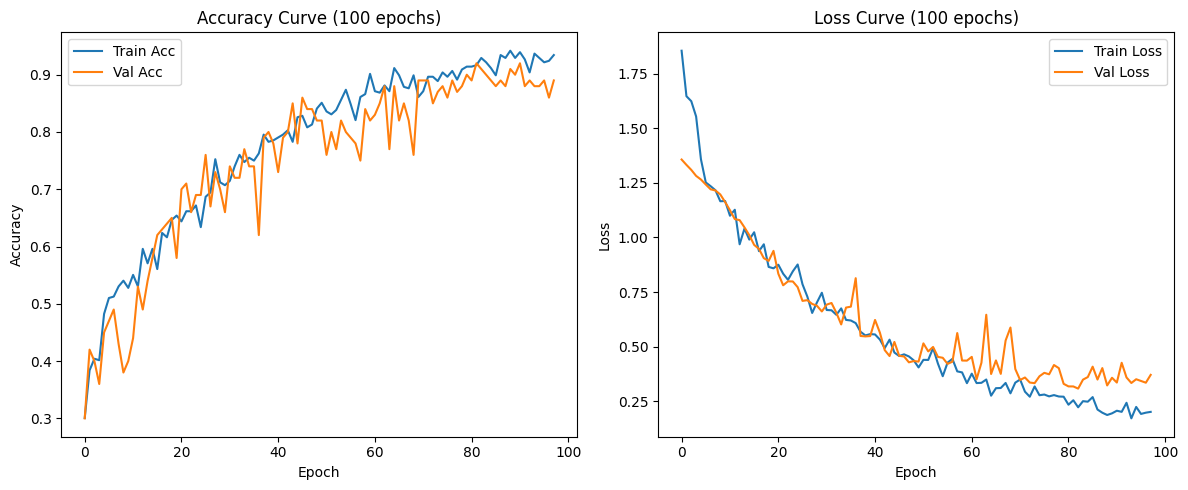

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



🚀 Training Extreme BiLSTM with 150 epochs...
Epoch 1/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2791 - loss: 1.8188

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.2841 - loss: 1.8081 - val_accuracy: 0.2400 - val_loss: 1.3846
Epoch 2/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3247 - loss: 1.6646

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3267 - loss: 1.6625 - val_accuracy: 0.3400 - val_loss: 1.3662
Epoch 3/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3658 - loss: 1.6086

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3647 - loss: 1.6090 - val_accuracy: 0.3800 - val_loss: 1.3570
Epoch 4/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4131 - loss: 1.4482

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4132 - loss: 1.4517 - val_accuracy: 0.4000 - val_loss: 1.3388
Epoch 5/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4284 - loss: 1.3175

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4316 - loss: 1.3158 - val_accuracy: 0.4600 - val_loss: 1.2958
Epoch 6/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4639 - loss: 1.3641

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4613 - loss: 1.3625 - val_accuracy: 0.5000 - val_loss: 1.2696
Epoch 7/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5095 - loss: 1.2859

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5074 - loss: 1.2837 - val_accuracy: 0.5900 - val_loss: 1.2491
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5178 - loss: 1.1448 - val_accuracy: 0.5600 - val_loss: 1.2267
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5233 - loss: 1.1975 - val_accuracy: 0.3900 - val_loss: 1.2337
Epoch 10/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5355 - loss: 1.2085 - val_accuracy: 0.4500 - val_loss: 1.1905
Epoch 11/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5851 - loss: 1.1247 - val_accuracy: 0.4700 - val_loss: 1.1516
Epoch 12/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5856 - loss: 1.0456 - val_accuracy: 0.4500 - val_loss: 1.1734
Epoch 13/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5928 - loss: 1.0288 - val_accuracy: 0.5900 - val_loss: 1.1238
Epoch 14/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5909 - loss: 0.9750

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5905 - loss: 0.9791 - val_accuracy: 0.6000 - val_loss: 1.0756
Epoch 15/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5967 - loss: 1.0521 - val_accuracy: 0.6000 - val_loss: 1.0392
Epoch 16/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6279 - loss: 1.0028 - val_accuracy: 0.5700 - val_loss: 1.0389
Epoch 17/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6454 - loss: 1.0063 - val_accuracy: 0.3800 - val_loss: 1.2259
Epoch 18/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6177 - loss: 0.9211 - val_accuracy: 0.4300 - val_loss: 1.1006
Epoch 19/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6445 - loss: 0.9125 - val_accuracy: 0.4800 - val_loss: 1.0785
Epoch 20/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5905 - loss: 0.9580 - val_accuracy: 0.3800 - val_loss: 1.1595
Epoch 21/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6331 - loss: 0.8588 - val_accuracy: 0.4400 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6842 - loss: 0.7082 - val_accuracy: 0.6600 - val_loss: 0.8379
Epoch 30/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6978 - loss: 0.7307

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6963 - loss: 0.7346 - val_accuracy: 0.7600 - val_loss: 0.7097
Epoch 31/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7154 - loss: 0.7547 - val_accuracy: 0.7300 - val_loss: 0.7636
Epoch 32/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7175 - loss: 0.7104 - val_accuracy: 0.5800 - val_loss: 0.8805
Epoch 33/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7364 - loss: 0.6507 - val_accuracy: 0.6900 - val_loss: 0.7609
Epoch 34/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7302 - loss: 0.6693 - val_accuracy: 0.6600 - val_loss: 0.7484
Epoch 35/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7059 - loss: 0.7141 - val_accuracy: 0.6500 - val_loss: 0.8696
Epoch 36/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7249 - loss: 0.7343 - val_accuracy: 0.6800 - val_loss: 0.7450
Epoch 37/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7101 - loss: 0.7015 - val_accuracy: 0.7000 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8249 - loss: 0.5073 - val_accuracy: 0.7700 - val_loss: 0.5933
Epoch 48/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8156 - loss: 0.4939 - val_accuracy: 0.7600 - val_loss: 0.5758
Epoch 49/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8023 - loss: 0.4872

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8015 - loss: 0.4905 - val_accuracy: 0.8000 - val_loss: 0.5981
Epoch 50/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8133 - loss: 0.4635 - val_accuracy: 0.8000 - val_loss: 0.6647
Epoch 51/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8544 - loss: 0.4357

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8521 - loss: 0.4345 - val_accuracy: 0.8200 - val_loss: 0.5598
Epoch 52/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8419 - loss: 0.4348 - val_accuracy: 0.8200 - val_loss: 0.5367
Epoch 53/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8263 - loss: 0.4671 - val_accuracy: 0.8000 - val_loss: 0.5940
Epoch 54/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7977 - loss: 0.4827 - val_accuracy: 0.7800 - val_loss: 0.6426
Epoch 55/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8272 - loss: 0.4819 - val_accuracy: 0.7900 - val_loss: 0.6715
Epoch 56/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8441 - loss: 0.4227 - val_accuracy: 0.7100 - val_loss: 0.7594
Epoch 57/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8470 - loss: 0.4538 - val_accuracy: 0.7400 - val_loss: 0.6874
Epoch 58/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8773 - loss: 0.3519 - val_accuracy: 0.7500 

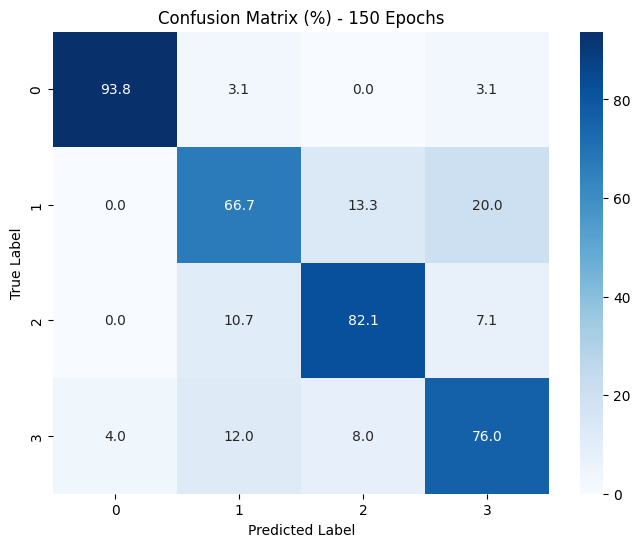

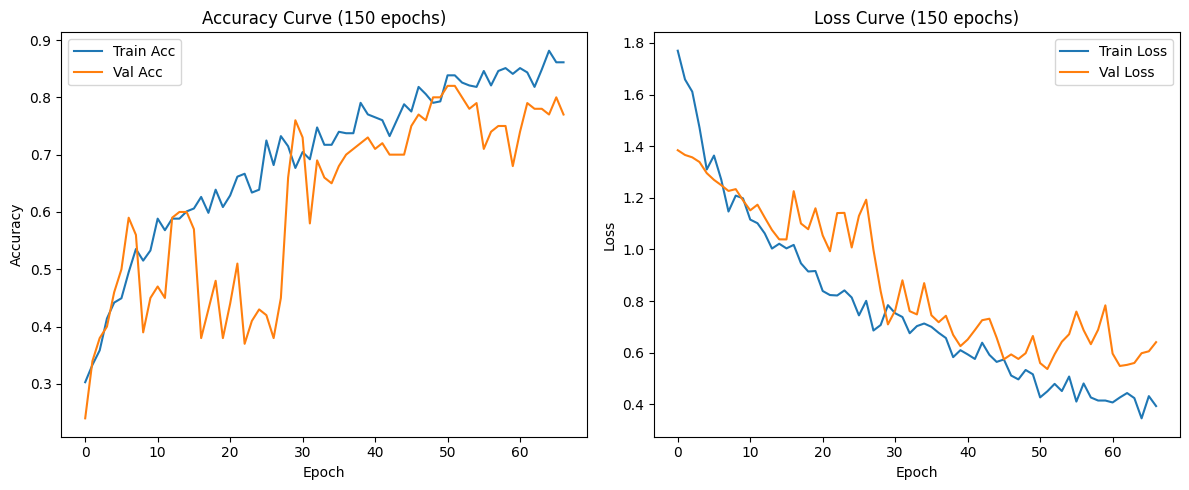

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



🚀 Training Extreme BiLSTM with 200 epochs...
Epoch 1/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2653 - loss: 1.7224

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.2682 - loss: 1.7271 - val_accuracy: 0.3000 - val_loss: 1.3414
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3133 - loss: 1.6446

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3149 - loss: 1.6420 - val_accuracy: 0.4600 - val_loss: 1.3119
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3848 - loss: 1.5566 - val_accuracy: 0.4400 - val_loss: 1.2977
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4572 - loss: 1.3817 - val_accuracy: 0.4000 - val_loss: 1.2844
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4549 - loss: 1.3082 - val_accuracy: 0.4500 - val_loss: 1.2744
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4772 - loss: 1.2236

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4781 - loss: 1.2230 - val_accuracy: 0.4800 - val_loss: 1.2539
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4865 - loss: 1.2394

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4846 - loss: 1.2424 - val_accuracy: 0.5200 - val_loss: 1.2216
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5069 - loss: 1.2275 - val_accuracy: 0.5100 - val_loss: 1.2062
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5457 - loss: 1.1490 - val_accuracy: 0.4500 - val_loss: 1.2027
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5042 - loss: 1.2558 - val_accuracy: 0.4500 - val_loss: 1.1700
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5261 - loss: 1.0890 - val_accuracy: 0.4500 - val_loss: 1.1500
Epoch 12/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5545 - loss: 1.0436

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5568 - loss: 1.0417 - val_accuracy: 0.5900 - val_loss: 1.0975
Epoch 13/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5501 - loss: 1.0476 - val_accuracy: 0.5700 - val_loss: 1.0799
Epoch 14/200
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5631 - loss: 1.0109

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5593 - loss: 1.0242 - val_accuracy: 0.6100 - val_loss: 1.0491
Epoch 15/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6106 - loss: 0.9584 - val_accuracy: 0.5700 - val_loss: 1.0778
Epoch 16/200
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6377 - loss: 0.9624

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6377 - loss: 0.9627 - val_accuracy: 0.6300 - val_loss: 1.0515
Epoch 17/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5938 - loss: 0.9857 - val_accuracy: 0.6200 - val_loss: 1.0040
Epoch 18/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5821 - loss: 0.9875 - val_accuracy: 0.5900 - val_loss: 0.9858
Epoch 19/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6362 - loss: 0.9010 - val_accuracy: 0.5300 - val_loss: 1.0235
Epoch 20/200
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6506 - loss: 0.9083

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6532 - loss: 0.8926 - val_accuracy: 0.6500 - val_loss: 0.9157
Epoch 21/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6181 - loss: 0.8461 - val_accuracy: 0.6200 - val_loss: 0.9310
Epoch 22/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6116 - loss: 0.9670 - val_accuracy: 0.5800 - val_loss: 0.9621
Epoch 23/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6259 - loss: 0.8864 - val_accuracy: 0.5900 - val_loss: 0.9390
Epoch 24/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7067 - loss: 0.7439

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7048 - loss: 0.7479 - val_accuracy: 0.7600 - val_loss: 0.8275
Epoch 25/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6602 - loss: 0.8038 - val_accuracy: 0.6800 - val_loss: 0.7719
Epoch 26/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6563 - loss: 0.8506 - val_accuracy: 0.6500 - val_loss: 0.7970
Epoch 27/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6112 - loss: 0.8753

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6126 - loss: 0.8757 - val_accuracy: 0.7900 - val_loss: 0.7106
Epoch 28/200
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6941 - loss: 0.7783

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6889 - loss: 0.7794 - val_accuracy: 0.8000 - val_loss: 0.6712
Epoch 29/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6455 - loss: 0.8316

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6514 - loss: 0.8235 - val_accuracy: 0.8500 - val_loss: 0.6333
Epoch 30/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6742 - loss: 0.8277 - val_accuracy: 0.8100 - val_loss: 0.6178
Epoch 31/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7057 - loss: 0.7357 - val_accuracy: 0.8200 - val_loss: 0.6335
Epoch 32/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7314 - loss: 0.7281 - val_accuracy: 0.7300 - val_loss: 0.6952
Epoch 33/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6977 - loss: 0.7293 - val_accuracy: 0.7300 - val_loss: 0.6956
Epoch 34/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7244 - loss: 0.6773 - val_accuracy: 0.8000 - val_loss: 0.6400
Epoch 35/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7011 - loss: 0.7273 - val_accuracy: 0.7500 - val_loss: 0.6799
Epoch 36/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6834 - loss: 0.7601 - val_accuracy: 0.7300 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7761 - loss: 0.6003 - val_accuracy: 0.8600 - val_loss: 0.5281
Epoch 53/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8030 - loss: 0.4871 - val_accuracy: 0.8300 - val_loss: 0.5072
Epoch 54/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8322 - loss: 0.4645 - val_accuracy: 0.7700 - val_loss: 0.6157
Epoch 55/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8715 - loss: 0.3941 - val_accuracy: 0.8100 - val_loss: 0.5709
Epoch 56/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8378 - loss: 0.4408

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8390 - loss: 0.4396 - val_accuracy: 0.8700 - val_loss: 0.4454
Epoch 57/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8579 - loss: 0.4663

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8563 - loss: 0.4655 - val_accuracy: 0.8800 - val_loss: 0.4780
Epoch 58/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8705 - loss: 0.3514

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8689 - loss: 0.3552 - val_accuracy: 0.8900 - val_loss: 0.3903
Epoch 59/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8318 - loss: 0.4799 - val_accuracy: 0.8400 - val_loss: 0.5155
Epoch 60/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8591 - loss: 0.3640 - val_accuracy: 0.7800 - val_loss: 0.5380
Epoch 61/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8425 - loss: 0.3987 - val_accuracy: 0.8100 - val_loss: 0.5941
Epoch 62/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8218 - loss: 0.3758 - val_accuracy: 0.8000 - val_loss: 0.6169
Epoch 63/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8284 - loss: 0.4336 - val_accuracy: 0.7200 - val_loss: 0.7522
Epoch 64/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8111 - loss: 0.4684 - val_accuracy: 0.8600 - val_loss: 0.4513
Epoch 65/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8395 - loss: 0.4314 - val_accuracy: 0.8600 

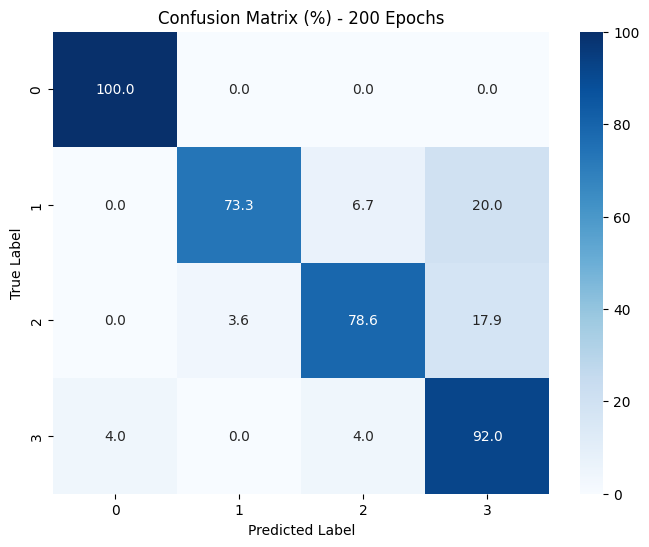

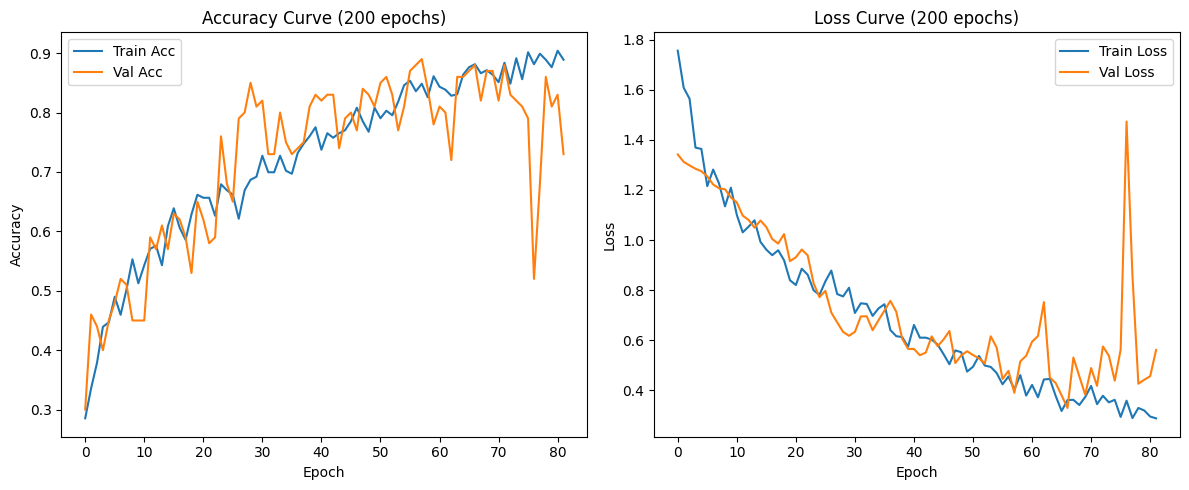

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



🚀 Training Extreme BiLSTM with 250 epochs...
Epoch 1/250
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2665 - loss: 1.9012

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.2681 - loss: 1.8961 - val_accuracy: 0.3500 - val_loss: 1.3466
Epoch 2/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3059 - loss: 1.7729 - val_accuracy: 0.3200 - val_loss: 1.3385
Epoch 3/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3516 - loss: 1.5839 - val_accuracy: 0.3500 - val_loss: 1.3242
Epoch 4/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3615 - loss: 1.5306 - val_accuracy: 0.3400 - val_loss: 1.3136
Epoch 5/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3984 - loss: 1.4321

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3983 - loss: 1.4301 - val_accuracy: 0.3600 - val_loss: 1.3003
Epoch 6/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4330 - loss: 1.3563

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4351 - loss: 1.3522 - val_accuracy: 0.3800 - val_loss: 1.2875
Epoch 7/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4431 - loss: 1.3433

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4427 - loss: 1.3430 - val_accuracy: 0.4200 - val_loss: 1.2403
Epoch 8/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4833 - loss: 1.2950

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4821 - loss: 1.2948 - val_accuracy: 0.4700 - val_loss: 1.2060
Epoch 9/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4886 - loss: 1.1579 - val_accuracy: 0.4400 - val_loss: 1.1784
Epoch 10/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5274 - loss: 1.2100 - val_accuracy: 0.4500 - val_loss: 1.1505
Epoch 11/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5825 - loss: 1.0774 - val_accuracy: 0.4400 - val_loss: 1.1381
Epoch 12/250
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5440 - loss: 1.1092

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5426 - loss: 1.1116 - val_accuracy: 0.5100 - val_loss: 1.0800
Epoch 13/250
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6126 - loss: 0.9418

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6080 - loss: 0.9462 - val_accuracy: 0.6000 - val_loss: 1.0408
Epoch 14/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6077 - loss: 0.9522 - val_accuracy: 0.5000 - val_loss: 1.0297
Epoch 15/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5498 - loss: 1.0578 - val_accuracy: 0.5300 - val_loss: 1.0105
Epoch 16/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5711 - loss: 1.0280 - val_accuracy: 0.5700 - val_loss: 0.9448
Epoch 17/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6265 - loss: 0.9747 - val_accuracy: 0.5900 - val_loss: 0.9328
Epoch 18/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6399 - loss: 0.8843 - val_accuracy: 0.4800 - val_loss: 1.0350
Epoch 19/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6436 - loss: 0.9618 - val_accuracy: 0.5700 - val_loss: 0.9689
Epoch 20/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6167 - loss: 0.9294 - val_accuracy: 0.5600 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6031 - loss: 0.9439 - val_accuracy: 0.6500 - val_loss: 0.8400
Epoch 22/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6202 - loss: 0.9329 - val_accuracy: 0.5600 - val_loss: 0.9126
Epoch 23/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6445 - loss: 0.9297 - val_accuracy: 0.5700 - val_loss: 0.9407
Epoch 24/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6248 - loss: 0.9229 - val_accuracy: 0.5800 - val_loss: 0.8945
Epoch 25/250
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7020 - loss: 0.7979

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6965 - loss: 0.8078 - val_accuracy: 0.7700 - val_loss: 0.7379
Epoch 26/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6523 - loss: 0.8210 - val_accuracy: 0.7700 - val_loss: 0.7173
Epoch 27/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6687 - loss: 0.7770 - val_accuracy: 0.7500 - val_loss: 0.6991
Epoch 28/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6804 - loss: 0.7721 - val_accuracy: 0.7700 - val_loss: 0.6417
Epoch 29/250
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6273 - loss: 0.8606

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6361 - loss: 0.8432 - val_accuracy: 0.8000 - val_loss: 0.6321
Epoch 30/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6154 - loss: 0.8620 - val_accuracy: 0.7400 - val_loss: 0.6570
Epoch 31/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7209 - loss: 0.6980 - val_accuracy: 0.7800 - val_loss: 0.6114
Epoch 32/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7272 - loss: 0.6727 - val_accuracy: 0.7800 - val_loss: 0.6248
Epoch 33/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7733 - loss: 0.6264 - val_accuracy: 0.6400 - val_loss: 0.8411
Epoch 34/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6953 - loss: 0.7853 - val_accuracy: 0.7900 - val_loss: 0.6412
Epoch 35/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7335 - loss: 0.7054 - val_accuracy: 0.7500 - val_loss: 0.6240
Epoch 36/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7020 - loss: 0.7511 - val_accuracy: 0.7500 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7545 - loss: 0.6099 - val_accuracy: 0.8100 - val_loss: 0.5243
Epoch 43/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7541 - loss: 0.6462 - val_accuracy: 0.7400 - val_loss: 0.6316
Epoch 44/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8210 - loss: 0.4761 - val_accuracy: 0.7600 - val_loss: 0.5583
Epoch 45/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7875 - loss: 0.5367 - val_accuracy: 0.7700 - val_loss: 0.5995
Epoch 46/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7736 - loss: 0.5669 - val_accuracy: 0.8000 - val_loss: 0.6063
Epoch 47/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7554 - loss: 0.5866 - val_accuracy: 0.7300 - val_loss: 0.5490
Epoch 48/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7703 - loss: 0.6208 - val_accuracy: 0.8000 - val_loss: 0.5411
Epoch 49/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7509 - loss: 0.6107 - val_accuracy: 0.7200 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7678 - loss: 0.5150 - val_accuracy: 0.8600 - val_loss: 0.4016
Epoch 57/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8437 - loss: 0.4885 - val_accuracy: 0.8000 - val_loss: 0.5235
Epoch 58/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8421 - loss: 0.4594 - val_accuracy: 0.8400 - val_loss: 0.4230
Epoch 59/250
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8099 - loss: 0.4495

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8184 - loss: 0.4423 - val_accuracy: 0.8700 - val_loss: 0.3742
Epoch 60/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8682 - loss: 0.3471

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8663 - loss: 0.3523 - val_accuracy: 0.8800 - val_loss: 0.3815
Epoch 61/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8199 - loss: 0.4442 - val_accuracy: 0.8500 - val_loss: 0.4048
Epoch 62/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8583 - loss: 0.3697 - val_accuracy: 0.8800 - val_loss: 0.3828
Epoch 63/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8287 - loss: 0.4472 - val_accuracy: 0.8400 - val_loss: 0.4180
Epoch 64/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8425 - loss: 0.3991 - val_accuracy: 0.8300 - val_loss: 0.4412
Epoch 65/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8491 - loss: 0.4395 - val_accuracy: 0.7800 - val_loss: 0.5565
Epoch 66/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8567 - loss: 0.4096 - val_accuracy: 0.8400 - val_loss: 0.4443
Epoch 67/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8783 - loss: 0.3552 - val_accuracy: 0.8500 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8647 - loss: 0.3407 - val_accuracy: 0.9000 - val_loss: 0.3356
Epoch 72/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8538 - loss: 0.3224 - val_accuracy: 0.9000 - val_loss: 0.3712
Epoch 73/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8836 - loss: 0.3235 - val_accuracy: 0.8600 - val_loss: 0.3842
Epoch 74/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8541 - loss: 0.3954 - val_accuracy: 0.9000 - val_loss: 0.3744
Epoch 75/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8810 - loss: 0.3520 - val_accuracy: 0.9000 - val_loss: 0.3757
Epoch 76/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8688 - loss: 0.3296 - val_accuracy: 0.8800 - val_loss: 0.3886
Epoch 77/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8640 - loss: 0.3333 - val_accuracy: 0.8600 - val_loss: 0.3608
Epoch 78/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8706 - loss: 0.3194 - val_accuracy: 0.8900 

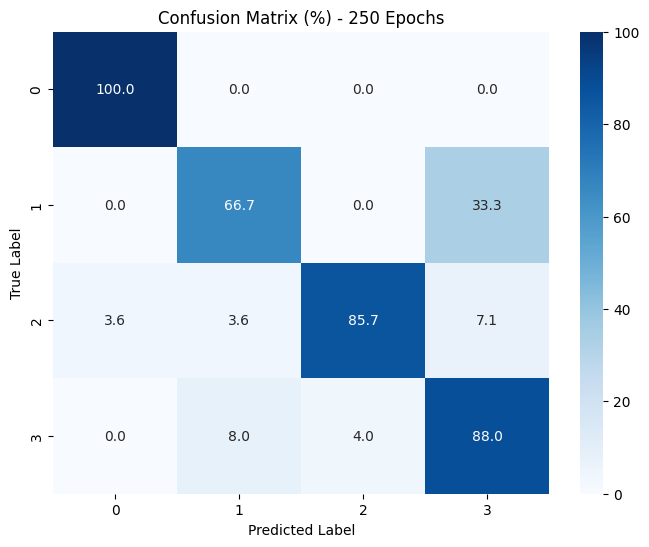

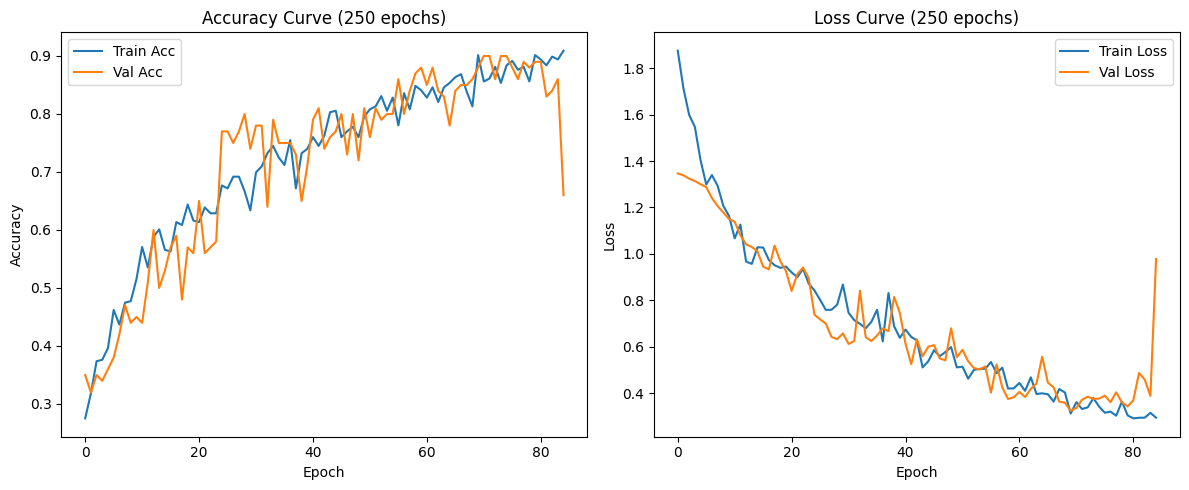


✅ Extreme BiLSTM training complete.

📊 Final Results Summary Table:
     accuracy  precision  recall        f1
100      0.91   0.910483    0.91  0.909206
150      0.82   0.826431    0.82  0.822694
200      0.88   0.889954    0.88  0.879579
250      0.88   0.884143    0.88  0.879508


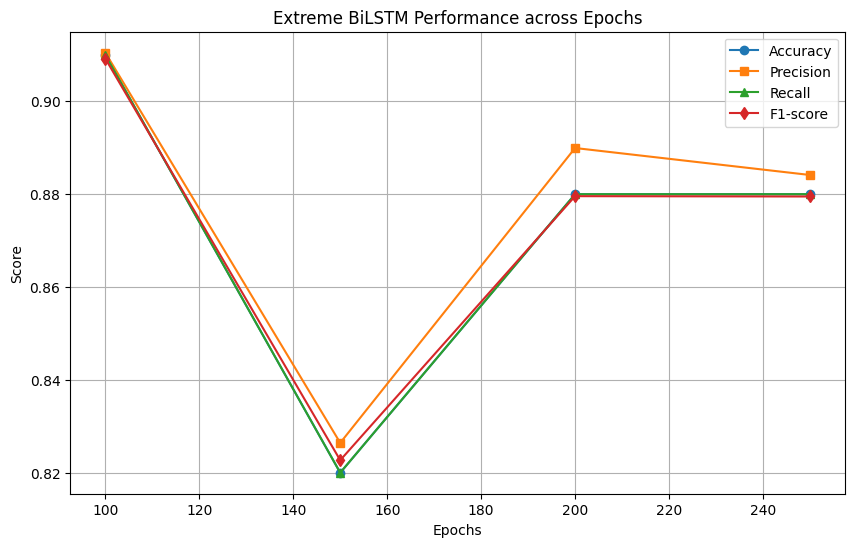

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Epoch values to iterate through
epochs_list = [100, 150, 200, 250]
# epochs_list = [100]

if X_train is not None and y_train is not None and X_test is not None and y_test is not None:

    num_classes = len(np.unique(y_train))
    results = {}

    for epochs in epochs_list:
        print(f"\n🚀 Training Extreme BiLSTM with {epochs} epochs...")

        # Extreme BiLSTM architecture
        model_bilstm = Sequential([
            Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
            BatchNormalization(),
            Dropout(0.3),

            Bidirectional(LSTM(64, return_sequences=False)),
            BatchNormalization(),
            Dropout(0.4),

            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        # Compile with smaller learning rate
        optimizer = Adam(learning_rate=1e-4)
        model_bilstm.compile(optimizer=optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        mc = ModelCheckpoint(f'bilstm_best_model_{epochs}.h5', monitor='val_accuracy', save_best_only=True)

        # Train model
        history = model_bilstm.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[es, mc],
            batch_size=32,
            verbose=1
        )

        # Evaluate model
        print(f"Evaluating BiLSTM trained with {epochs} epochs...")
        loss, accuracy = model_bilstm.evaluate(X_test, y_test, verbose=0)

        # Predictions
        y_pred_probs = model_bilstm.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Metrics
        precision = precision_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)

        print(f"📊 Results for {epochs} epochs:")
        print(f"  Accuracy: {accuracy * 100:.2f}%")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")

        # Classification report
        print("\n📑 Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # Confusion Matrix (percentage)
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        plt.figure(figsize=(8,6))
        sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues",
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f"Confusion Matrix (%) - {epochs} Epochs")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        # Accuracy & Loss curves
        plt.figure(figsize=(12,5))
        # Accuracy plot
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'Accuracy Curve ({epochs} epochs)')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Loss Curve ({epochs} epochs)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Save trained model
        model_bilstm.save(f"bilstm_model_{epochs}.h5")

        # Store results
        results[epochs] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    print("\n✅ Extreme BiLSTM training complete.")

    # Summary Table
    results_df = pd.DataFrame.from_dict(results, orient='index')
    print("\n📊 Final Results Summary Table:")
    print(results_df)

    # Plot comparison graph across epoch settings
    plt.figure(figsize=(10,6))
    plt.plot(results_df.index, results_df['accuracy'], marker='o', label='Accuracy')
    plt.plot(results_df.index, results_df['precision'], marker='s', label='Precision')
    plt.plot(results_df.index, results_df['recall'], marker='^', label='Recall')
    plt.plot(results_df.index, results_df['f1'], marker='d', label='F1-score')

    plt.title("Extreme BiLSTM Performance across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\n⚠ Data is not ready. Please check preprocessing.")


# **GRU**

1.  Epochs 100: Acc=0.8100, Precision=0.8059, Recall=0.8100, F1=0.8072



🚀 Training Extreme GRU with 100 epochs...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2410 - loss: 1.7488

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.2435 - loss: 1.7451 - val_accuracy: 0.3100 - val_loss: 1.4306
Epoch 2/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2797 - loss: 1.6485

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2823 - loss: 1.6465 - val_accuracy: 0.3200 - val_loss: 1.4103
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3425 - loss: 1.4684 - val_accuracy: 0.3200 - val_loss: 1.3830
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3731 - loss: 1.5123

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3699 - loss: 1.5131 - val_accuracy: 0.3800 - val_loss: 1.3545
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3821 - loss: 1.3771 - val_accuracy: 0.3600 - val_loss: 1.3234
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4118 - loss: 1.4300

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4130 - loss: 1.4269 - val_accuracy: 0.3900 - val_loss: 1.2959
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3917 - loss: 1.3979 - val_accuracy: 0.3700 - val_loss: 1.2836
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3886 - loss: 1.3467

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3881 - loss: 1.3496 - val_accuracy: 0.4900 - val_loss: 1.2633
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4327 - loss: 1.2606 - val_accuracy: 0.4500 - val_loss: 1.2624
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4405 - loss: 1.2536 - val_accuracy: 0.4900 - val_loss: 1.2182
Epoch 11/100
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4220 - loss: 1.3358

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4350 - loss: 1.3110 - val_accuracy: 0.5300 - val_loss: 1.1792
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4974 - loss: 1.2292 - val_accuracy: 0.4900 - val_loss: 1.1266
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5158 - loss: 1.1710

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5128 - loss: 1.1745 - val_accuracy: 0.5600 - val_loss: 1.0868
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5084 - loss: 1.1622

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5092 - loss: 1.1617 - val_accuracy: 0.5700 - val_loss: 1.0664
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5190 - loss: 1.1845 - val_accuracy: 0.5100 - val_loss: 1.0628
Epoch 16/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4819 - loss: 1.2203

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4817 - loss: 1.2166 - val_accuracy: 0.5900 - val_loss: 0.9989
Epoch 17/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4541 - loss: 1.2285 - val_accuracy: 0.5900 - val_loss: 0.9955
Epoch 18/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5024 - loss: 1.1475 - val_accuracy: 0.5600 - val_loss: 0.9864
Epoch 19/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5571 - loss: 1.1356 - val_accuracy: 0.5800 - val_loss: 0.9527
Epoch 20/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5066 - loss: 1.1614 - val_accuracy: 0.5100 - val_loss: 1.0439
Epoch 21/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5212 - loss: 1.0507 - val_accuracy: 0.5300 - val_loss: 1.0332
Epoch 22/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5529 - loss: 1.0728 - val_accuracy: 0.5600 - val_loss: 1.0222
Epoch 23/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5976 - loss: 0.9420

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5946 - loss: 0.9489 - val_accuracy: 0.6300 - val_loss: 0.9146
Epoch 24/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5181 - loss: 1.0720 - val_accuracy: 0.4900 - val_loss: 1.0313
Epoch 25/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5781 - loss: 0.9972

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5783 - loss: 1.0004 - val_accuracy: 0.7000 - val_loss: 0.9032
Epoch 26/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5363 - loss: 1.0051 - val_accuracy: 0.5300 - val_loss: 0.9879
Epoch 27/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5587 - loss: 1.0798 - val_accuracy: 0.4100 - val_loss: 1.2430
Epoch 28/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5531 - loss: 1.0455 - val_accuracy: 0.5100 - val_loss: 1.0151
Epoch 29/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5821 - loss: 1.0194 - val_accuracy: 0.5800 - val_loss: 0.9240
Epoch 30/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5801 - loss: 1.0618 - val_accuracy: 0.5600 - val_loss: 0.9036
Epoch 31/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5842 - loss: 0.9705 - val_accuracy: 0.6400 - val_loss: 0.8638
Epoch 32/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5770 - loss: 0.9516 - val_accuracy: 0.6900 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6380 - loss: 0.8559 - val_accuracy: 0.7200 - val_loss: 0.8014
Epoch 35/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6442 - loss: 0.8576 - val_accuracy: 0.6400 - val_loss: 0.8284
Epoch 36/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6455 - loss: 0.9072

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6458 - loss: 0.9066 - val_accuracy: 0.7300 - val_loss: 0.7366
Epoch 37/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6339 - loss: 0.8450 - val_accuracy: 0.7000 - val_loss: 0.7401
Epoch 38/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6224 - loss: 0.8963

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6227 - loss: 0.8965 - val_accuracy: 0.7400 - val_loss: 0.7002
Epoch 39/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6792 - loss: 0.8046 - val_accuracy: 0.7100 - val_loss: 0.7625
Epoch 40/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6619 - loss: 0.8000 - val_accuracy: 0.6700 - val_loss: 0.7720
Epoch 41/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7071 - loss: 0.7873 - val_accuracy: 0.7000 - val_loss: 0.7144
Epoch 42/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6831 - loss: 0.7774 - val_accuracy: 0.7400 - val_loss: 0.7008
Epoch 43/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6535 - loss: 0.8703 - val_accuracy: 0.7200 - val_loss: 0.7097
Epoch 44/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6458 - loss: 0.8355 - val_accuracy: 0.7100 - val_loss: 0.6997
Epoch 45/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6919 - loss: 0.7686 - val_accuracy: 0.7300 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6775 - loss: 0.8102 - val_accuracy: 0.7600 - val_loss: 0.6564
Epoch 48/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7069 - loss: 0.7201 - val_accuracy: 0.7200 - val_loss: 0.6737
Epoch 49/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6830 - loss: 0.7806 - val_accuracy: 0.7100 - val_loss: 0.7237
Epoch 50/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6739 - loss: 0.8597 - val_accuracy: 0.7000 - val_loss: 0.7030
Epoch 51/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6805 - loss: 0.8116 - val_accuracy: 0.7000 - val_loss: 0.7557
Epoch 52/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6891 - loss: 0.7665 - val_accuracy: 0.7000 - val_loss: 0.6750
Epoch 53/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6893 - loss: 0.7585 - val_accuracy: 0.7400 - val_loss: 0.6105
Epoch 54/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6955 - loss: 0.7500 - val_accuracy: 0.7400 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7233 - loss: 0.7180 - val_accuracy: 0.7900 - val_loss: 0.6284
Epoch 57/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7365 - loss: 0.6549 - val_accuracy: 0.7300 - val_loss: 0.6087
Epoch 58/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7117 - loss: 0.7080 - val_accuracy: 0.7400 - val_loss: 0.5871
Epoch 59/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6882 - loss: 0.7082 - val_accuracy: 0.7600 - val_loss: 0.5361
Epoch 60/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7062 - loss: 0.7077 - val_accuracy: 0.7200 - val_loss: 0.5790
Epoch 61/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7593 - loss: 0.6117 - val_accuracy: 0.7600 - val_loss: 0.5520
Epoch 62/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7287 - loss: 0.6735

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7300 - loss: 0.6717 - val_accuracy: 0.8100 - val_loss: 0.5198
Epoch 63/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7732 - loss: 0.6411 - val_accuracy: 0.7400 - val_loss: 0.6922
Epoch 64/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7290 - loss: 0.7091 - val_accuracy: 0.7600 - val_loss: 0.6238
Epoch 65/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7498 - loss: 0.6371 - val_accuracy: 0.7500 - val_loss: 0.5830
Epoch 66/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7606 - loss: 0.6209 - val_accuracy: 0.7300 - val_loss: 0.6487
Epoch 67/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7432 - loss: 0.6764 - val_accuracy: 0.7300 - val_loss: 0.5689
Epoch 68/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7125 - loss: 0.6251 - val_accuracy: 0.7700 - val_loss: 0.5784
Epoch 69/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7774 - loss: 0.5942 - val_accuracy: 0.7700 

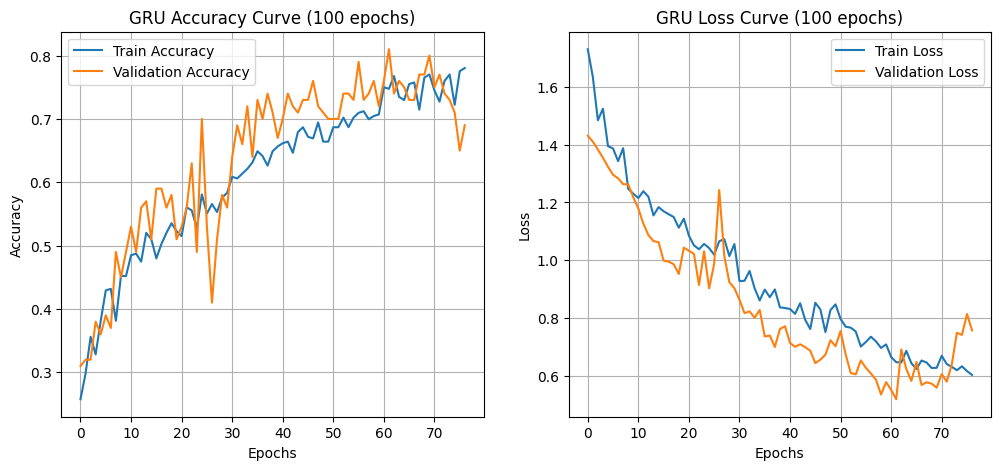

Evaluating GRU trained with 100 epochs...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
📊 Results for 100 epochs:
  Accuracy: 81.00%
  Precision: 0.8023
  Recall: 0.8100
  F1-score: 0.8049


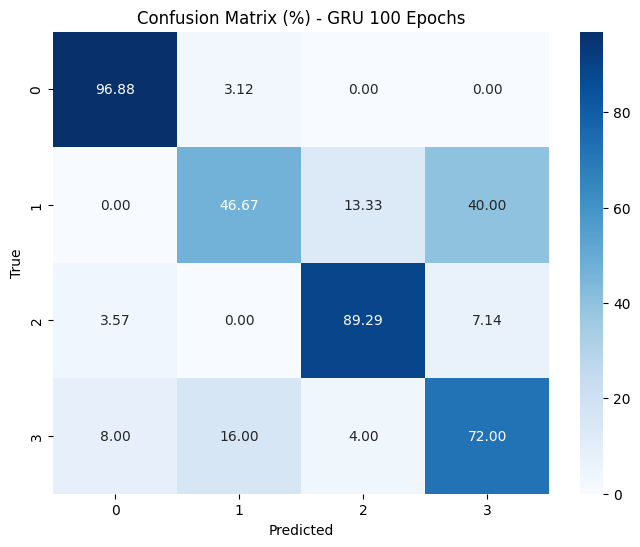


📑 Classification Report:
              precision    recall  f1-score   support

           0     0.9118    0.9688    0.9394        32
           1     0.5833    0.4667    0.5185        15
           2     0.8929    0.8929    0.8929        28
           3     0.6923    0.7200    0.7059        25

    accuracy                         0.8100       100
   macro avg     0.7701    0.7621    0.7642       100
weighted avg     0.8023    0.8100    0.8049       100


🚀 Training Extreme GRU with 150 epochs...
Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2758 - loss: 1.6568

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.2763 - loss: 1.6537 - val_accuracy: 0.3200 - val_loss: 1.3627
Epoch 2/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3272 - loss: 1.5167

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3370 - loss: 1.5074 - val_accuracy: 0.3600 - val_loss: 1.3478
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3428 - loss: 1.5066

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3423 - loss: 1.5084 - val_accuracy: 0.3900 - val_loss: 1.3360
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3849 - loss: 1.4441

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3854 - loss: 1.4422 - val_accuracy: 0.4000 - val_loss: 1.3086
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4515 - loss: 1.3010

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4507 - loss: 1.3054 - val_accuracy: 0.4500 - val_loss: 1.2898
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3911 - loss: 1.3329

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3914 - loss: 1.3361 - val_accuracy: 0.4600 - val_loss: 1.2790
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4798 - loss: 1.3060 - val_accuracy: 0.4600 - val_loss: 1.2584
Epoch 8/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4052 - loss: 1.3444

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4058 - loss: 1.3450 - val_accuracy: 0.4900 - val_loss: 1.2373
Epoch 9/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4318 - loss: 1.3503

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4322 - loss: 1.3426 - val_accuracy: 0.5000 - val_loss: 1.2160
Epoch 10/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4006 - loss: 1.3771 - val_accuracy: 0.4500 - val_loss: 1.2156
Epoch 11/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5116 - loss: 1.1905

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5113 - loss: 1.1925 - val_accuracy: 0.5100 - val_loss: 1.1817
Epoch 12/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4956 - loss: 1.1714

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4954 - loss: 1.1725 - val_accuracy: 0.5300 - val_loss: 1.1527
Epoch 13/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4959 - loss: 1.2364

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4966 - loss: 1.2325 - val_accuracy: 0.5600 - val_loss: 1.0968
Epoch 14/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4760 - loss: 1.2376 - val_accuracy: 0.5600 - val_loss: 1.0974
Epoch 15/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5554 - loss: 1.0830

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5525 - loss: 1.0854 - val_accuracy: 0.5700 - val_loss: 1.1089
Epoch 16/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4980 - loss: 1.2133 - val_accuracy: 0.5500 - val_loss: 1.0719
Epoch 17/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5570 - loss: 1.0318

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5559 - loss: 1.0335 - val_accuracy: 0.5800 - val_loss: 1.0476
Epoch 18/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5432 - loss: 1.0720

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5416 - loss: 1.0742 - val_accuracy: 0.5900 - val_loss: 1.0580
Epoch 19/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5629 - loss: 1.0913 - val_accuracy: 0.5700 - val_loss: 1.0758
Epoch 20/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5324 - loss: 1.1344 - val_accuracy: 0.5600 - val_loss: 1.0658
Epoch 21/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5617 - loss: 0.9885 - val_accuracy: 0.5500 - val_loss: 1.0550
Epoch 22/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6113 - loss: 1.0111 - val_accuracy: 0.4700 - val_loss: 1.0758
Epoch 23/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5097 - loss: 1.0659

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5120 - loss: 1.0641 - val_accuracy: 0.6100 - val_loss: 0.9826
Epoch 24/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5988 - loss: 0.9986

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5991 - loss: 0.9971 - val_accuracy: 0.6300 - val_loss: 0.9408
Epoch 25/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5837 - loss: 1.0681 - val_accuracy: 0.6100 - val_loss: 0.8981
Epoch 26/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6089 - loss: 0.9566 - val_accuracy: 0.6100 - val_loss: 0.8885
Epoch 27/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6231 - loss: 0.8667 - val_accuracy: 0.5800 - val_loss: 1.0044
Epoch 28/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5980 - loss: 0.9737 - val_accuracy: 0.5900 - val_loss: 0.9709
Epoch 29/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5685 - loss: 0.9119 - val_accuracy: 0.5600 - val_loss: 0.9621
Epoch 30/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5608 - loss: 1.0345

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5643 - loss: 1.0275 - val_accuracy: 0.6600 - val_loss: 0.9199
Epoch 31/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6302 - loss: 0.9553

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6295 - loss: 0.9559 - val_accuracy: 0.6900 - val_loss: 0.8518
Epoch 32/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6113 - loss: 0.9059 - val_accuracy: 0.6500 - val_loss: 0.8784
Epoch 33/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5765 - loss: 0.9708 - val_accuracy: 0.6800 - val_loss: 0.8504
Epoch 34/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5848 - loss: 0.9928 - val_accuracy: 0.6400 - val_loss: 0.8513
Epoch 35/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6008 - loss: 0.9355

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6024 - loss: 0.9331 - val_accuracy: 0.7000 - val_loss: 0.7566
Epoch 36/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6369 - loss: 0.8635 - val_accuracy: 0.6300 - val_loss: 0.8382
Epoch 37/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6179 - loss: 0.8861 - val_accuracy: 0.7000 - val_loss: 0.7398
Epoch 38/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6313 - loss: 0.8580

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6328 - loss: 0.8618 - val_accuracy: 0.7100 - val_loss: 0.8018
Epoch 39/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6690 - loss: 0.8778

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6671 - loss: 0.8775 - val_accuracy: 0.7300 - val_loss: 0.7494
Epoch 40/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7463 - loss: 0.7328 - val_accuracy: 0.7000 - val_loss: 0.8129
Epoch 41/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6823 - loss: 0.7982 - val_accuracy: 0.6400 - val_loss: 0.8580
Epoch 42/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7145 - loss: 0.7628 - val_accuracy: 0.6400 - val_loss: 0.8396
Epoch 43/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6751 - loss: 0.8575 - val_accuracy: 0.6300 - val_loss: 0.8391
Epoch 44/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6893 - loss: 0.7261 - val_accuracy: 0.6400 - val_loss: 0.8568
Epoch 45/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6745 - loss: 0.7712 - val_accuracy: 0.6300 - val_loss: 0.8951
Epoch 46/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6895 - loss: 0.7216 - val_accuracy: 0.7000 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6974 - loss: 0.7539 - val_accuracy: 0.7400 - val_loss: 0.7365
Epoch 49/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7051 - loss: 0.7371 - val_accuracy: 0.7200 - val_loss: 0.7498
Epoch 50/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7111 - loss: 0.7279 - val_accuracy: 0.6700 - val_loss: 0.6963
Epoch 51/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7387 - loss: 0.7410 - val_accuracy: 0.6800 - val_loss: 0.7032
Epoch 52/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7441 - loss: 0.6376 - val_accuracy: 0.7100 - val_loss: 0.6668
Epoch 53/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7893 - loss: 0.6530 - val_accuracy: 0.7200 - val_loss: 0.6375
Epoch 54/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7597 - loss: 0.6177

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7586 - loss: 0.6202 - val_accuracy: 0.7500 - val_loss: 0.6141
Epoch 55/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7501 - loss: 0.6493

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7499 - loss: 0.6496 - val_accuracy: 0.8000 - val_loss: 0.5777
Epoch 56/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7609 - loss: 0.6126 - val_accuracy: 0.7600 - val_loss: 0.6275
Epoch 57/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7190 - loss: 0.6520 - val_accuracy: 0.7800 - val_loss: 0.5813
Epoch 58/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7219 - loss: 0.6516 - val_accuracy: 0.8000 - val_loss: 0.5306
Epoch 59/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7599 - loss: 0.6121 - val_accuracy: 0.7800 - val_loss: 0.5672
Epoch 60/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7885 - loss: 0.6032

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7872 - loss: 0.6040 - val_accuracy: 0.8100 - val_loss: 0.5858
Epoch 61/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7588 - loss: 0.6584 - val_accuracy: 0.7700 - val_loss: 0.5858
Epoch 62/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7339 - loss: 0.6104 - val_accuracy: 0.7900 - val_loss: 0.5574
Epoch 63/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7870 - loss: 0.5612 - val_accuracy: 0.7800 - val_loss: 0.6050
Epoch 64/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7596 - loss: 0.5643 - val_accuracy: 0.8000 - val_loss: 0.6401
Epoch 65/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7992 - loss: 0.5213 - val_accuracy: 0.7600 - val_loss: 0.5743
Epoch 66/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7720 - loss: 0.5467

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7725 - loss: 0.5488 - val_accuracy: 0.8200 - val_loss: 0.5394
Epoch 67/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8053 - loss: 0.5776 - val_accuracy: 0.7400 - val_loss: 0.6485
Epoch 68/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7732 - loss: 0.5868 - val_accuracy: 0.7900 - val_loss: 0.5756
Epoch 69/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8108 - loss: 0.5063 - val_accuracy: 0.7900 - val_loss: 0.5993
Epoch 70/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7865 - loss: 0.5351 - val_accuracy: 0.8100 - val_loss: 0.5770
Epoch 71/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7994 - loss: 0.5050

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7978 - loss: 0.5082 - val_accuracy: 0.8500 - val_loss: 0.5248
Epoch 72/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8282 - loss: 0.4935 - val_accuracy: 0.8400 - val_loss: 0.5254
Epoch 73/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8464 - loss: 0.4750 - val_accuracy: 0.8300 - val_loss: 0.5205
Epoch 74/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8192 - loss: 0.4884 - val_accuracy: 0.6800 - val_loss: 0.8080
Epoch 75/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8503 - loss: 0.4293 - val_accuracy: 0.7200 - val_loss: 0.6877
Epoch 76/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7812 - loss: 0.5627 - val_accuracy: 0.7200 - val_loss: 0.6990
Epoch 77/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7984 - loss: 0.5010 - val_accuracy: 0.7900 - val_loss: 0.6039
Epoch 78/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7852 - loss: 0.5314 - val_accuracy: 0.7300 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8517 - loss: 0.3630 - val_accuracy: 0.8700 - val_loss: 0.4126
Epoch 96/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8711 - loss: 0.3582 - val_accuracy: 0.8700 - val_loss: 0.4321
Epoch 97/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9060 - loss: 0.3053 - val_accuracy: 0.8600 - val_loss: 0.4643
Epoch 98/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8632 - loss: 0.3556 - val_accuracy: 0.8300 - val_loss: 0.4932
Epoch 99/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8995 - loss: 0.3044 - val_accuracy: 0.8500 - val_loss: 0.4635
Epoch 100/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8780 - loss: 0.3078 - val_accuracy: 0.8600 - val_loss: 0.4870
Epoch 101/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9172 - loss: 0.3109 - val_accuracy: 0.8400 - val_loss: 0.4816
Epoch 102/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9039 - loss: 0.2769 - val_accuracy: 0.85

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8673 - loss: 0.3564 - val_accuracy: 0.8800 - val_loss: 0.4073
Epoch 104/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8568 - loss: 0.3500

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8585 - loss: 0.3469 - val_accuracy: 0.9000 - val_loss: 0.4012
Epoch 105/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8975 - loss: 0.3386 - val_accuracy: 0.8700 - val_loss: 0.4532
Epoch 106/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8996 - loss: 0.2998 - val_accuracy: 0.8500 - val_loss: 0.4424
Epoch 107/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9035 - loss: 0.2692 - val_accuracy: 0.8600 - val_loss: 0.5012
Epoch 108/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9201 - loss: 0.2533 - val_accuracy: 0.7900 - val_loss: 0.5690
Epoch 109/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8384 - loss: 0.4414 - val_accuracy: 0.8600 - val_loss: 0.5326
Epoch 110/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8733 - loss: 0.3061 - val_accuracy: 0.8400 - val_loss: 0.4683
Epoch 111/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9123 - loss: 0.2610 - val_accuracy: 

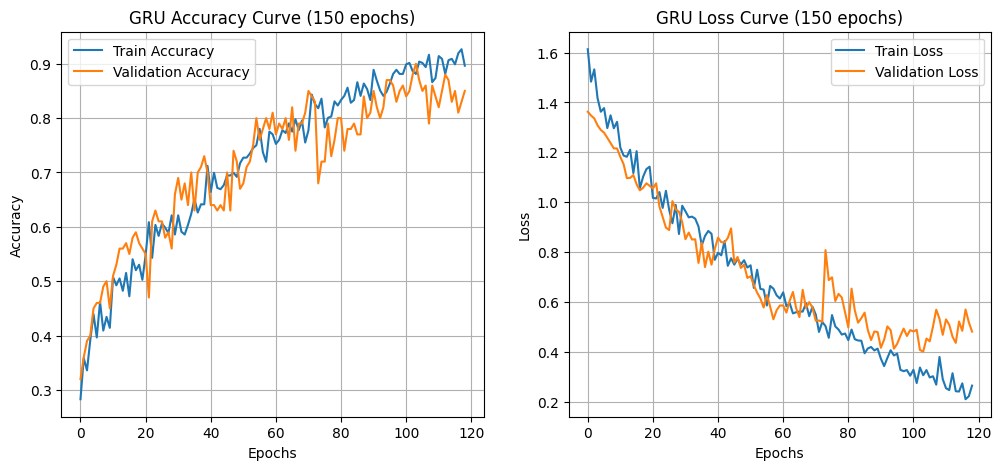

Evaluating GRU trained with 150 epochs...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
📊 Results for 150 epochs:
  Accuracy: 90.00%
  Precision: 0.9049
  Recall: 0.9000
  F1-score: 0.8999


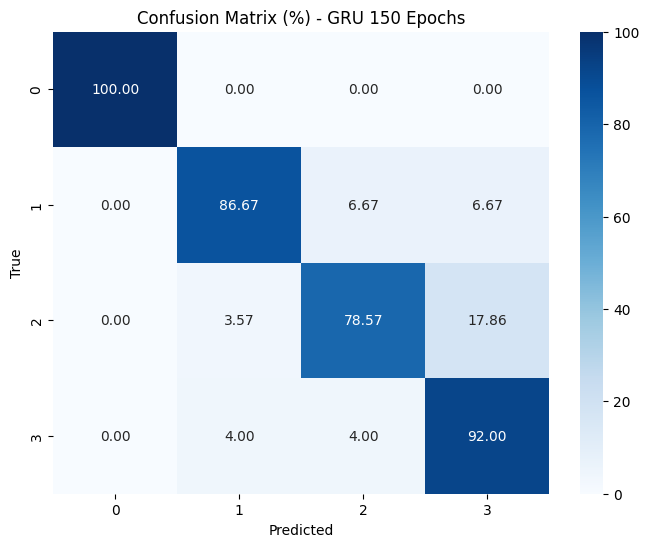


📑 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        32
           1     0.8667    0.8667    0.8667        15
           2     0.9167    0.7857    0.8462        28
           3     0.7931    0.9200    0.8519        25

    accuracy                         0.9000       100
   macro avg     0.8941    0.8931    0.8912       100
weighted avg     0.9049    0.9000    0.8999       100


🚀 Training Extreme GRU with 200 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2536 - loss: 1.8314

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.2537 - loss: 1.8303 - val_accuracy: 0.1300 - val_loss: 1.5209
Epoch 2/200
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2457 - loss: 1.7220

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2385 - loss: 1.7230 - val_accuracy: 0.1400 - val_loss: 1.4912
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2712 - loss: 1.6516 - val_accuracy: 0.1400 - val_loss: 1.4774
Epoch 4/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3416 - loss: 1.5272

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3390 - loss: 1.5336 - val_accuracy: 0.2100 - val_loss: 1.4227
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3402 - loss: 1.4228 - val_accuracy: 0.1800 - val_loss: 1.3957
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4638 - loss: 1.3625

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4588 - loss: 1.3705 - val_accuracy: 0.2600 - val_loss: 1.3658
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4407 - loss: 1.3436

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4383 - loss: 1.3460 - val_accuracy: 0.2800 - val_loss: 1.3606
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4443 - loss: 1.2694

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4420 - loss: 1.2732 - val_accuracy: 0.3200 - val_loss: 1.3310
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3943 - loss: 1.3043

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3963 - loss: 1.3051 - val_accuracy: 0.3700 - val_loss: 1.2825
Epoch 10/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3919 - loss: 1.3604

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3943 - loss: 1.3540 - val_accuracy: 0.4200 - val_loss: 1.2377
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4610 - loss: 1.2940

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4608 - loss: 1.2931 - val_accuracy: 0.4800 - val_loss: 1.2208
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4151 - loss: 1.3163

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4157 - loss: 1.3178 - val_accuracy: 0.4900 - val_loss: 1.2244
Epoch 13/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4420 - loss: 1.2377

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4412 - loss: 1.2386 - val_accuracy: 0.5100 - val_loss: 1.1796
Epoch 14/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4017 - loss: 1.3809

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4042 - loss: 1.3764 - val_accuracy: 0.5300 - val_loss: 1.1674
Epoch 15/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4430 - loss: 1.2197

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4436 - loss: 1.2250 - val_accuracy: 0.5500 - val_loss: 1.1182
Epoch 16/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4960 - loss: 1.2586 - val_accuracy: 0.5000 - val_loss: 1.1587
Epoch 17/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4879 - loss: 1.1769

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4862 - loss: 1.1813 - val_accuracy: 0.5700 - val_loss: 1.1223
Epoch 18/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4723 - loss: 1.1842

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4741 - loss: 1.1799 - val_accuracy: 0.6100 - val_loss: 1.0679
Epoch 19/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5249 - loss: 1.1530 - val_accuracy: 0.5800 - val_loss: 1.0442
Epoch 20/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4928 - loss: 1.1544 - val_accuracy: 0.5900 - val_loss: 1.0283
Epoch 21/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4949 - loss: 1.1361 - val_accuracy: 0.5900 - val_loss: 1.0403
Epoch 22/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5409 - loss: 1.1263 - val_accuracy: 0.6100 - val_loss: 1.0173
Epoch 23/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5182 - loss: 1.1654 - val_accuracy: 0.6000 - val_loss: 1.0038
Epoch 24/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4920 - loss: 1.1614

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4924 - loss: 1.1587 - val_accuracy: 0.6300 - val_loss: 1.0179
Epoch 25/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5465 - loss: 1.0856

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5470 - loss: 1.0878 - val_accuracy: 0.6800 - val_loss: 0.9516
Epoch 26/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6007 - loss: 1.0437

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6000 - loss: 1.0437 - val_accuracy: 0.6900 - val_loss: 0.9372
Epoch 27/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5120 - loss: 1.0862 - val_accuracy: 0.5800 - val_loss: 0.9205
Epoch 28/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5867 - loss: 1.0491 - val_accuracy: 0.6000 - val_loss: 0.9595
Epoch 29/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5531 - loss: 1.0147 - val_accuracy: 0.5900 - val_loss: 0.9952
Epoch 30/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5410 - loss: 1.0626 - val_accuracy: 0.5600 - val_loss: 0.9959
Epoch 31/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5743 - loss: 1.0339 - val_accuracy: 0.6600 - val_loss: 0.9561
Epoch 32/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5791 - loss: 1.0151 - val_accuracy: 0.6800 - val_loss: 0.8890
Epoch 33/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6083 - loss: 0.9353 - val_accuracy: 0.6300 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6959 - loss: 0.7891 - val_accuracy: 0.7100 - val_loss: 0.8361
Epoch 43/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6445 - loss: 0.8591 - val_accuracy: 0.6000 - val_loss: 0.9180
Epoch 44/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6321 - loss: 0.9188 - val_accuracy: 0.6100 - val_loss: 0.9498
Epoch 45/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6557 - loss: 0.8265 - val_accuracy: 0.6500 - val_loss: 0.9140
Epoch 46/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6835 - loss: 0.7711 - val_accuracy: 0.6400 - val_loss: 0.8939
Epoch 47/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6991 - loss: 0.7216 - val_accuracy: 0.6500 - val_loss: 0.9172
Epoch 48/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6954 - loss: 0.7408 - val_accuracy: 0.6500 - val_loss: 0.8761
Epoch 49/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6833 - loss: 0.7657 - val_accuracy: 0.6200 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7020 - loss: 0.7566 - val_accuracy: 0.7300 - val_loss: 0.8221
Epoch 57/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7563 - loss: 0.6674 - val_accuracy: 0.7100 - val_loss: 0.8452
Epoch 58/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7340 - loss: 0.7497 - val_accuracy: 0.7100 - val_loss: 0.8267
Epoch 59/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7522 - loss: 0.6328

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7510 - loss: 0.6362 - val_accuracy: 0.7500 - val_loss: 0.7028
Epoch 60/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7743 - loss: 0.6116 - val_accuracy: 0.7500 - val_loss: 0.7255
Epoch 61/200
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7300 - loss: 0.7076

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7303 - loss: 0.7059 - val_accuracy: 0.7700 - val_loss: 0.7275
Epoch 62/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7152 - loss: 0.7256 - val_accuracy: 0.7200 - val_loss: 0.7040
Epoch 63/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7368 - loss: 0.6739 - val_accuracy: 0.7500 - val_loss: 0.6737
Epoch 64/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7381 - loss: 0.6999 - val_accuracy: 0.7100 - val_loss: 0.7040
Epoch 65/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7621 - loss: 0.6381 - val_accuracy: 0.7000 - val_loss: 0.6906
Epoch 66/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7665 - loss: 0.6012 - val_accuracy: 0.6800 - val_loss: 0.7748
Epoch 67/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7945 - loss: 0.5954 - val_accuracy: 0.7200 - val_loss: 0.7380
Epoch 68/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8290 - loss: 0.5269 - val_accuracy: 0.7100 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8220 - loss: 0.4707 - val_accuracy: 0.7900 - val_loss: 0.5506
Epoch 84/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8243 - loss: 0.4703 - val_accuracy: 0.7600 - val_loss: 0.6725
Epoch 85/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7602 - loss: 0.5879 - val_accuracy: 0.7500 - val_loss: 0.6303
Epoch 86/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8227 - loss: 0.4725

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8228 - loss: 0.4732 - val_accuracy: 0.8000 - val_loss: 0.5669
Epoch 87/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8570 - loss: 0.4840 - val_accuracy: 0.7800 - val_loss: 0.5717
Epoch 88/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8429 - loss: 0.4770 - val_accuracy: 0.7500 - val_loss: 0.5931
Epoch 89/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7911 - loss: 0.4914 - val_accuracy: 0.7200 - val_loss: 0.5904
Epoch 90/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8229 - loss: 0.4677 - val_accuracy: 0.7300 - val_loss: 0.5926
Epoch 91/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8238 - loss: 0.5193 - val_accuracy: 0.7700 - val_loss: 0.5599
Epoch 92/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8350 - loss: 0.4378 - val_accuracy: 0.7500 - val_loss: 0.5948
Epoch 93/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8134 - loss: 0.5246 - val_accuracy: 0.7600 

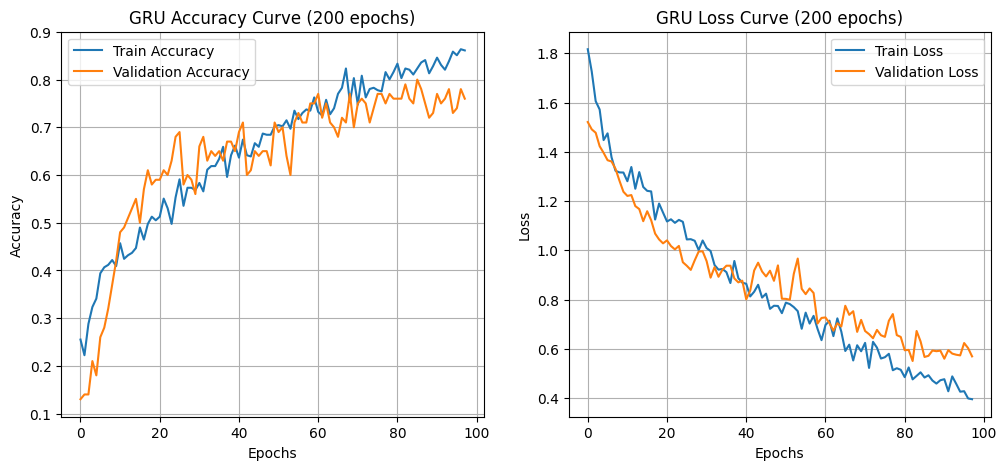

Evaluating GRU trained with 200 epochs...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
📊 Results for 200 epochs:
  Accuracy: 79.00%
  Precision: 0.7862
  Recall: 0.7900
  F1-score: 0.7858


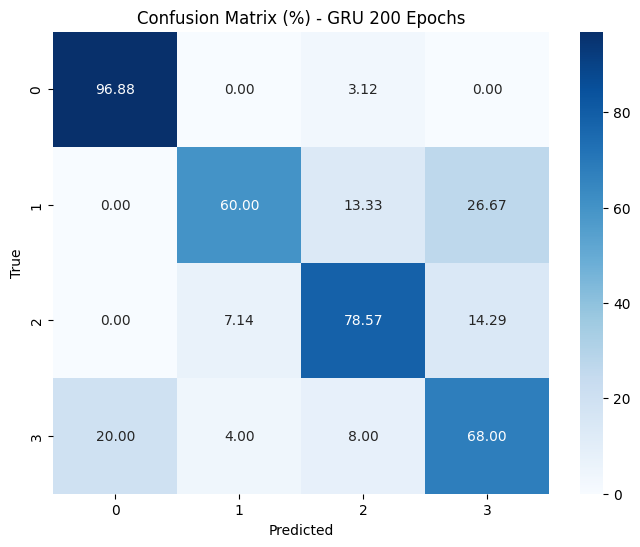


📑 Classification Report:
              precision    recall  f1-score   support

           0     0.8611    0.9688    0.9118        32
           1     0.7500    0.6000    0.6667        15
           2     0.8148    0.7857    0.8000        28
           3     0.6800    0.6800    0.6800        25

    accuracy                         0.7900       100
   macro avg     0.7765    0.7586    0.7646       100
weighted avg     0.7862    0.7900    0.7858       100


🚀 Training Extreme GRU with 250 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2480 - loss: 1.7263

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.2497 - loss: 1.7205 - val_accuracy: 0.2600 - val_loss: 1.3761
Epoch 2/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2909 - loss: 1.6374 - val_accuracy: 0.2400 - val_loss: 1.3518
Epoch 3/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3218 - loss: 1.4896

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3231 - loss: 1.4916 - val_accuracy: 0.2900 - val_loss: 1.3263
Epoch 4/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3470 - loss: 1.5205

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3484 - loss: 1.5191 - val_accuracy: 0.3400 - val_loss: 1.2853
Epoch 5/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3513 - loss: 1.4552

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3531 - loss: 1.4557 - val_accuracy: 0.4200 - val_loss: 1.2526
Epoch 6/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3587 - loss: 1.4086

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3580 - loss: 1.4109 - val_accuracy: 0.4600 - val_loss: 1.2356
Epoch 7/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4375 - loss: 1.2978 - val_accuracy: 0.4600 - val_loss: 1.2124
Epoch 8/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4177 - loss: 1.3169

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4143 - loss: 1.3197 - val_accuracy: 0.4800 - val_loss: 1.1978
Epoch 9/250
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3137 - loss: 1.4688

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3270 - loss: 1.4514 - val_accuracy: 0.5200 - val_loss: 1.1695
Epoch 10/250
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4387 - loss: 1.2928

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4378 - loss: 1.2911 - val_accuracy: 0.5600 - val_loss: 1.1237
Epoch 11/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4160 - loss: 1.2589 - val_accuracy: 0.5600 - val_loss: 1.1262
Epoch 12/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4580 - loss: 1.2196

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4561 - loss: 1.2218 - val_accuracy: 0.5700 - val_loss: 1.1014
Epoch 13/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4634 - loss: 1.2344

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4635 - loss: 1.2329 - val_accuracy: 0.6000 - val_loss: 1.0642
Epoch 14/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4168 - loss: 1.2649

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4182 - loss: 1.2620 - val_accuracy: 0.6100 - val_loss: 1.0226
Epoch 15/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4116 - loss: 1.2443

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4136 - loss: 1.2435 - val_accuracy: 0.6400 - val_loss: 1.0188
Epoch 16/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4548 - loss: 1.2462 - val_accuracy: 0.6400 - val_loss: 1.0056
Epoch 17/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4761 - loss: 1.1849 - val_accuracy: 0.6300 - val_loss: 1.0036
Epoch 18/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4707 - loss: 1.2398 - val_accuracy: 0.5900 - val_loss: 1.0055
Epoch 19/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4833 - loss: 1.1083 - val_accuracy: 0.5400 - val_loss: 1.0034
Epoch 20/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5352 - loss: 1.0674 - val_accuracy: 0.6100 - val_loss: 0.9333
Epoch 21/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4770 - loss: 1.1574 - val_accuracy: 0.6400 - val_loss: 0.9460
Epoch 22/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5536 - loss: 1.0971 - val_accuracy: 0.5900 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6419 - loss: 0.9301 - val_accuracy: 0.6500 - val_loss: 0.7975
Epoch 31/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5528 - loss: 0.9605

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5564 - loss: 0.9572 - val_accuracy: 0.6900 - val_loss: 0.8005
Epoch 32/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4858 - loss: 1.0716 - val_accuracy: 0.6400 - val_loss: 0.7979
Epoch 33/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6100 - loss: 0.9512 - val_accuracy: 0.6900 - val_loss: 0.8337
Epoch 34/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 0.9979 - val_accuracy: 0.6100 - val_loss: 0.7857
Epoch 35/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5778 - loss: 0.9890

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5773 - loss: 0.9869 - val_accuracy: 0.7200 - val_loss: 0.7344
Epoch 36/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6250 - loss: 0.9359 - val_accuracy: 0.7200 - val_loss: 0.7461
Epoch 37/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6411 - loss: 0.8775 - val_accuracy: 0.7200 - val_loss: 0.7350
Epoch 38/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6205 - loss: 0.8904

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6206 - loss: 0.8904 - val_accuracy: 0.7400 - val_loss: 0.7041
Epoch 39/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6186 - loss: 0.9255 - val_accuracy: 0.7200 - val_loss: 0.7004
Epoch 40/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6250 - loss: 0.9411 - val_accuracy: 0.6600 - val_loss: 0.7183
Epoch 41/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6403 - loss: 0.9097 - val_accuracy: 0.7300 - val_loss: 0.6910
Epoch 42/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6546 - loss: 0.8126 - val_accuracy: 0.7200 - val_loss: 0.6896
Epoch 43/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6672 - loss: 0.8109 - val_accuracy: 0.7300 - val_loss: 0.7153
Epoch 44/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6651 - loss: 0.8584

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6628 - loss: 0.8609 - val_accuracy: 0.7600 - val_loss: 0.6979
Epoch 45/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6541 - loss: 0.8534 - val_accuracy: 0.7400 - val_loss: 0.6906
Epoch 46/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6502 - loss: 0.8170 - val_accuracy: 0.7200 - val_loss: 0.7284
Epoch 47/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6765 - loss: 0.8294 - val_accuracy: 0.7300 - val_loss: 0.7446
Epoch 48/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6855 - loss: 0.7673 - val_accuracy: 0.6500 - val_loss: 0.7936
Epoch 49/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6368 - loss: 0.8551 - val_accuracy: 0.6900 - val_loss: 0.7802
Epoch 50/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6610 - loss: 0.8241 - val_accuracy: 0.6600 - val_loss: 0.7300
Epoch 51/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6824 - loss: 0.8208 - val_accuracy: 0.6700 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6701 - loss: 0.8494 - val_accuracy: 0.7700 - val_loss: 0.6762
Epoch 56/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7122 - loss: 0.7277 - val_accuracy: 0.7500 - val_loss: 0.6666
Epoch 57/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7059 - loss: 0.7554 - val_accuracy: 0.7700 - val_loss: 0.6151
Epoch 58/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7239 - loss: 0.6928

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7223 - loss: 0.6946 - val_accuracy: 0.7800 - val_loss: 0.6006
Epoch 59/250
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7297 - loss: 0.6774

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7258 - loss: 0.6818 - val_accuracy: 0.8000 - val_loss: 0.6223
Epoch 60/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7325 - loss: 0.7124

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7314 - loss: 0.7147 - val_accuracy: 0.8400 - val_loss: 0.5993
Epoch 61/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7278 - loss: 0.7105 - val_accuracy: 0.8200 - val_loss: 0.5854
Epoch 62/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7633 - loss: 0.6279 - val_accuracy: 0.7900 - val_loss: 0.5738
Epoch 63/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7075 - loss: 0.7402 - val_accuracy: 0.7400 - val_loss: 0.5786
Epoch 64/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7504 - loss: 0.6722 - val_accuracy: 0.8000 - val_loss: 0.5499
Epoch 65/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7492 - loss: 0.6357 - val_accuracy: 0.8100 - val_loss: 0.5618
Epoch 66/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7456 - loss: 0.6542 - val_accuracy: 0.8100 - val_loss: 0.5600
Epoch 67/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7089 - loss: 0.6998 - val_accuracy: 0.8200 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7883 - loss: 0.5205 - val_accuracy: 0.8600 - val_loss: 0.5351
Epoch 86/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8291 - loss: 0.4704 - val_accuracy: 0.8400 - val_loss: 0.5201
Epoch 87/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8190 - loss: 0.4842 - val_accuracy: 0.8600 - val_loss: 0.5494
Epoch 88/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7692 - loss: 0.5633 - val_accuracy: 0.8400 - val_loss: 0.5399
Epoch 89/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8402 - loss: 0.4779 - val_accuracy: 0.8400 - val_loss: 0.5394
Epoch 90/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8543 - loss: 0.4362 - val_accuracy: 0.7200 - val_loss: 0.6949
Epoch 91/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8086 - loss: 0.4858 - val_accuracy: 0.8200 - val_loss: 0.5595
Epoch 92/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8084 - loss: 0.5038 - val_accuracy: 0.7300 

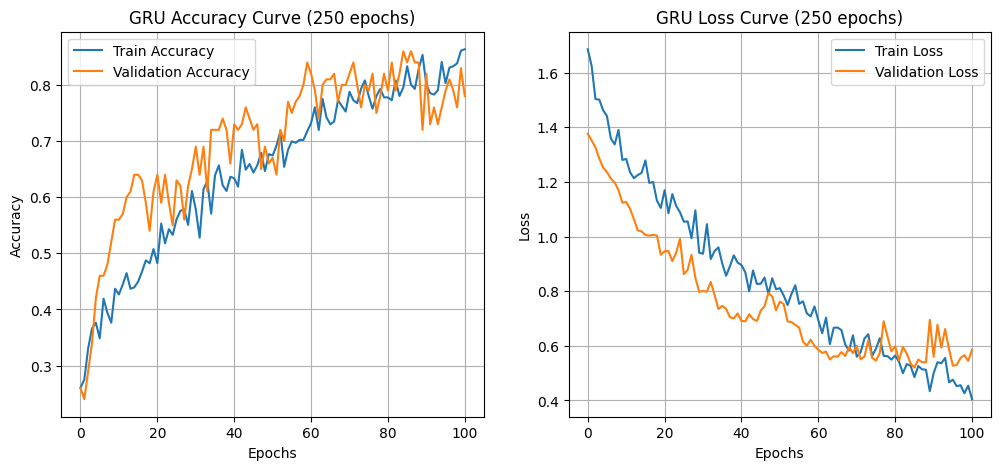

Evaluating GRU trained with 250 epochs...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
📊 Results for 250 epochs:
  Accuracy: 84.00%
  Precision: 0.8496
  Recall: 0.8400
  F1-score: 0.8388


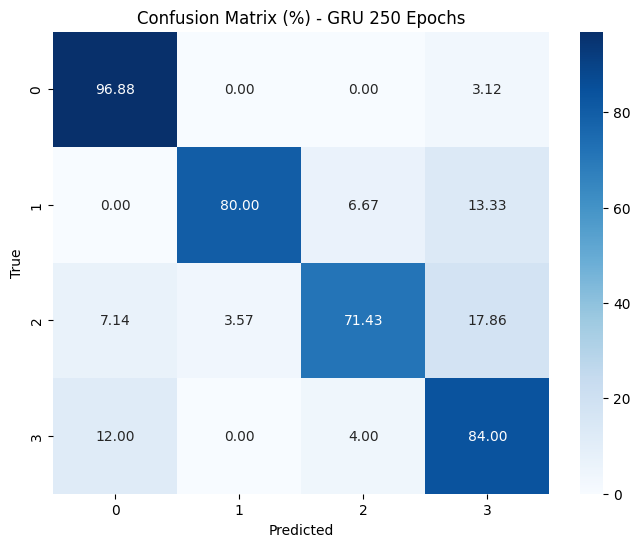


📑 Classification Report:
              precision    recall  f1-score   support

           0     0.8611    0.9688    0.9118        32
           1     0.9231    0.8000    0.8571        15
           2     0.9091    0.7143    0.8000        28
           3     0.7241    0.8400    0.7778        25

    accuracy                         0.8400       100
   macro avg     0.8544    0.8308    0.8367       100
weighted avg     0.8496    0.8400    0.8388       100


✅ Extreme GRU training complete.

📊 Final Results Summary:
     accuracy  precision  recall        f1
100      0.81   0.802342    0.81  0.804854
150      0.90   0.904943    0.90  0.899886
200      0.79   0.786204    0.79  0.785765
250      0.84   0.849597    0.84  0.838781


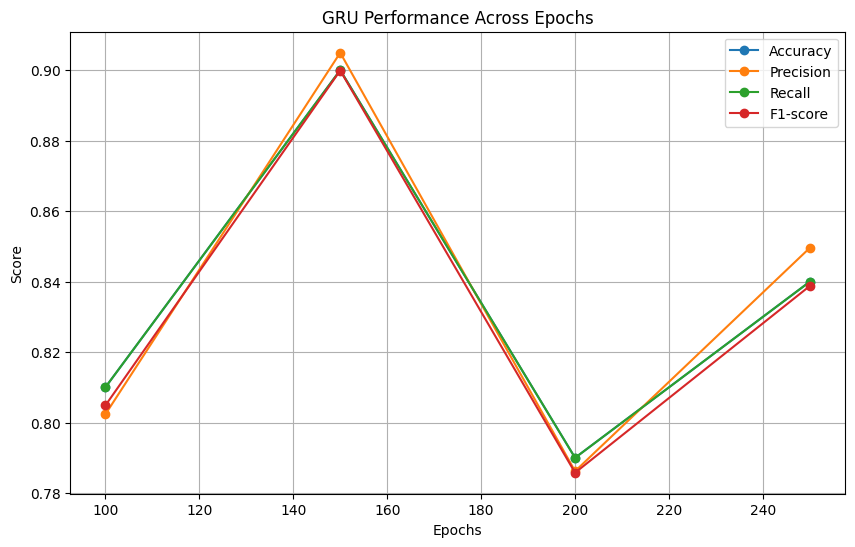

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd

# Epoch values to iterate through
epochs_list = [100, 150, 200, 250]

if X_train is not None and y_train is not None and X_test is not None and y_test is not None:

    num_classes = len(np.unique(y_train))
    results = {}

    for epochs in epochs_list:
        print(f"\n🚀 Training Extreme GRU with {epochs} epochs...")

        # Extreme GRU architecture
        model_gru = Sequential([
            GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            BatchNormalization(),
            Dropout(0.3),

            GRU(64, return_sequences=False),
            BatchNormalization(),
            Dropout(0.4),

            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        # Compile
        optimizer = Adam(learning_rate=1e-4)
        model_gru.compile(optimizer=optimizer,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        mc = ModelCheckpoint(f'gru_best_model_{epochs}.h5', monitor='val_accuracy', save_best_only=True)

        # Train
        history = model_gru.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[es, mc],
            batch_size=32,
            verbose=1
        )

        # =======================
        # 📈 Plot Loss & Accuracy Curves
        # =======================
        plt.figure(figsize=(12, 5))
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'GRU Accuracy Curve ({epochs} epochs)')
        plt.legend()
        plt.grid(True)
        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'GRU Loss Curve ({epochs} epochs)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Evaluate
        print(f"Evaluating GRU trained with {epochs} epochs...")
        loss, accuracy = model_gru.evaluate(X_test, y_test, verbose=0)

        # Predictions
        y_pred_probs = model_gru.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Metrics
        precision = precision_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, labels=np.unique(y_test), average='weighted', zero_division=0)

        print(f"📊 Results for {epochs} epochs:")
        print(f"  Accuracy: {accuracy * 100:.2f}%")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")

        # Confusion Matrix (percentage)
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix (%) - GRU {epochs} Epochs")
        plt.show()

        # Classification Report
        print("\n📑 Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # Save trained model
        model_gru.save(f"gru_model_{epochs}.h5")

        # Store results
        results[epochs] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    # =======================
    # ✅ Final Results Summary
    # =======================
    print("\n✅ Extreme GRU training complete.")
    results_df = pd.DataFrame(results).T
    print("\n📊 Final Results Summary:")
    print(results_df)

    # =======================
    # 📈 Plot Metric Trends Across Epochs
    # =======================
    plt.figure(figsize=(10, 6))
    plt.plot(results_df.index, results_df['accuracy'], marker='o', label="Accuracy")
    plt.plot(results_df.index, results_df['precision'], marker='o', label="Precision")
    plt.plot(results_df.index, results_df['recall'], marker='o', label="Recall")
    plt.plot(results_df.index, results_df['f1'], marker='o', label="F1-score")

    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("GRU Performance Across Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\n⚠ Data is not ready. Please check preprocessing.")
